# 변경 후
- EDA부터 차근차근 할 예정

**할일**
1. SEED 3가지의 경우에 실행 후 평균
2. AutoGluon 모델의 성능이 가장 좋음
3. MinMax 성능 재측정
4.



Feature Info : https://docs.google.com/spreadsheets/d/1LYXp_pty8WQWHr7YYIMmSD8qyKu208IfCycvRRKZulE/edit#gid=0

In [1]:
%cd /content/drive/MyDrive/dacon/hyundai_ai

/content/drive/MyDrive/dacon/hyundai_ai


In [6]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [2]:
!pip install autogluon pytorch_tabnet -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.7/285.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.3/372.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.p

In [3]:
import os, gc, random
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
import lightgbm as lgb
import bisect
from pytorch_tabnet.tab_model import TabNetRegressor
from autogluon.tabular import TabularPredictor, TabularDataset

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 123
seed_everything(SEED) # Seed 고정

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED) # Seed 고정

In [5]:
df_train = pd.read_csv('./data/train.csv').drop(columns=['SAMPLE_ID','ID'])
df_test = pd.read_csv('./data/test.csv').drop(columns=['SAMPLE_ID','ID'])

# CI_HOUR
- 대기시간
- Target Value

**결과**
- 0값이 굉장히 많음
  - 0의 값들 특징
  1. `DIST` 가 0이면 대부분 대기시간이 없음 -> 정박지와 접안지 사이의 거리가 없기 때문에
  2. `DIST` 가 0인데 `CI_HOUR` 가 0이 아닌 값들을 한번 비교

- Log Transpose를 통해 왼쪽 쏠림 현상을 완화

In [7]:
df_train['CI_HOUR'] = df_train['CI_HOUR'] * 60

In [8]:
df_train['CI_HOUR'] = np.log1p(df_train['CI_HOUR'])

In [9]:
df_train_dist0 = df_train[df_train['DIST']==0]
df_train = df_train[df_train['DIST']>0]

df_test_dist0 = df_test[df_test['DIST']==0]
df_test = df_test[df_test['DIST']>0]

In [ ]:
df_train['CI_HOUR'].describe()

count    234646.000000
mean          7.620855
std           1.582590
min           0.154151
25%           6.637504
50%           7.678407
75%           8.697082
max          11.771813
Name: CI_HOUR, dtype: float64

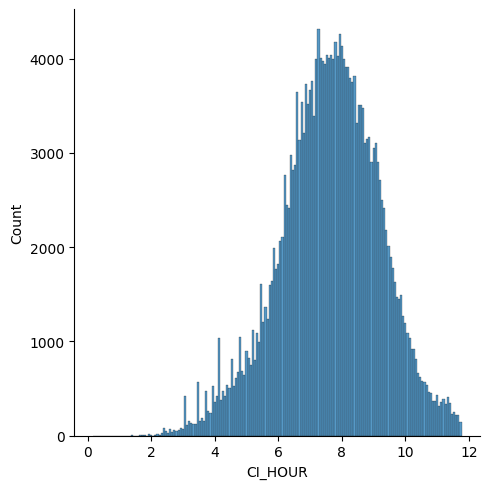

In [ ]:
sns.displot(df_train['CI_HOUR'])

0인 데이터의 분포와 0이 아닐때의 분포로 나누는 것이 적합하다고 생각
DIST가 0일 때 대기시간이 없는 경우를 보자

In [ ]:
df_train[df_train['CI_HOUR']<=6.637504].describe()

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
count,58662.000000,58662.000000,58662.000000,58662.000000,58662.000000,58662.000000,58662.000000,58662.000000,35795.000000,35795.000000,35624.000000,35795.000000,58662.000000,58662.000000,58662.000000
mean,20.740961,28.382258,15.564624,48472.459514,15.155637,10.290819,34264.100440,191.322492,-0.288109,-0.222560,19.755833,2.540258,11.242781,0.001053,5.571543
std,25.491934,10.800203,7.438227,53529.940240,6.322788,4.357490,36983.377417,78.224576,3.057126,3.586386,9.610408,1.379403,6.857054,0.000915,0.932050
min,0.000262,10.000000,0.000000,100.000000,0.000000,0.000000,150.000000,20.000000,-15.280000,-20.460000,-24.700000,0.000000,0.000000,0.000005,0.154151
25%,5.953290,20.000000,10.000000,12200.000000,10.000000,10.000000,9440.000000,140.000000,-1.950000,-2.040000,13.300000,1.679965,6.000000,0.000256,5.042349
50%,12.069766,30.000000,15.000000,28400.000000,10.000000,10.000000,20900.000000,180.000000,-0.130000,0.000000,22.900000,2.463029,11.000000,0.000939,5.861569
75%,25.475987,30.000000,20.000000,63400.000000,20.000000,10.000000,42600.000000,250.000000,1.310000,1.870000,27.100000,3.351616,17.000000,0.001743,6.305849
max,199.400002,60.000000,71.000000,404000.000000,30.000000,20.000000,237000.000000,400.000000,17.910000,29.690000,47.600000,11.179660,23.000000,0.002615,6.637498


In [ ]:
df_train[(df_train['CI_HOUR']>6.637504) & (df_train['CI_HOUR']<8.697082)].describe()

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
count,117322.000000,117322.000000,117322.000000,117322.000000,117322.000000,117322.000000,117322.000000,117322.000000,70266.000000,70266.000000,69972.000000,70266.000000,117322.000000,117322.000000,117322.000000
mean,37.432530,30.742742,14.643289,69030.248376,16.454885,11.396243,41711.564157,204.115426,-0.221990,-0.002814,18.872869,2.688123,12.071095,0.000915,7.673433
std,36.219241,10.928103,7.085455,68485.506266,5.815438,4.797252,37790.340693,73.582388,3.299311,3.558882,9.767781,1.307742,6.704308,0.000846,0.576295
min,0.001170,10.000000,0.000000,100.000000,0.000000,0.000000,150.000000,20.000000,-19.230000,-21.450000,-27.400000,0.000000,0.000000,0.000005,6.637520
25%,11.981862,20.000000,10.000000,15500.000000,10.000000,10.000000,11300.000000,150.000000,-2.140000,-2.060000,11.900000,1.837026,7.000000,0.000130,7.190441
50%,24.762100,30.000000,13.000000,50500.000000,20.000000,10.000000,32300.000000,190.000000,-0.180000,0.000000,21.600000,2.615549,12.000000,0.000557,7.678407
75%,48.410483,40.000000,18.000000,84300.000000,20.000000,10.000000,54000.000000,260.000000,1.570000,2.190000,26.600000,3.506212,18.000000,0.001660,8.157418
max,199.980651,60.000000,71.000000,404000.000000,30.000000,20.000000,237000.000000,400.000000,16.320000,16.610000,47.500000,9.334660,23.000000,0.002615,8.697067


In [ ]:
df_train[df_train['CI_HOUR']>=8.697082].describe()

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
count,58662.000000,58662.000000,58662.000000,58662.000000,58662.000000,58662.000000,58662.000000,58662.000000,36140.000000,36140.000000,36009.000000,36140.000000,58662.000000,58662.000000,58662.000000
mean,33.532865,32.438717,14.392315,85476.745934,17.513723,11.992431,48739.626334,213.795131,-0.382162,-0.023397,19.662523,2.718254,11.801149,0.000740,9.565015
std,35.459718,11.582567,7.353364,76403.344341,5.704156,5.274427,41113.256246,73.952570,3.480810,3.478060,9.955635,1.325525,6.814991,0.000901,0.707362
min,0.000478,10.000000,0.000000,100.000000,0.000000,0.000000,150.000000,20.000000,-20.080000,-20.190000,-32.200000,0.000000,0.000000,0.000005,8.697087
25%,11.516557,30.000000,10.000000,27600.000000,10.000000,10.000000,18200.000000,180.000000,-2.320000,-2.060000,13.600000,1.838128,6.000000,0.000080,9.014042
50%,23.947954,30.000000,13.000000,63300.000000,20.000000,10.000000,38400.000000,220.000000,-0.240000,0.000000,23.100000,2.647067,12.000000,0.000320,9.371186
75%,38.932684,40.000000,18.000000,119000.000000,20.000000,20.000000,88400.000000,290.000000,1.490000,2.060000,27.200000,3.580117,18.000000,0.001614,9.946669
max,199.922390,60.000000,65.000000,404000.000000,30.000000,20.000000,237000.000000,400.000000,17.350000,29.690000,47.000000,11.179660,23.000000,0.002615,11.771813


In [ ]:
df_train[df_train['CI_HOUR'] < 1].describe()

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
count,7.000000,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,2.00000,2.000000,2.000000,2.000000,7.000000,7.000000,7.000000
mean,0.023960,41.428571,11.714286,137857.142857,20.0,15.714286,74128.571429,264.285714,0.17500,2.060000,15.900000,1.837147,9.285714,0.000061,0.668939
std,0.018298,8.997354,4.386125,67340.227134,0.0,5.345225,32306.176617,41.975049,0.53033,1.018234,0.848528,0.558011,5.851333,0.000062,0.279996
min,0.006160,30.000000,8.000000,35800.000000,20.0,10.000000,30000.000000,210.000000,-0.20000,1.340000,15.300000,1.442573,0.000000,0.000005,0.154151
25%,0.013770,35.000000,9.500000,85600.000000,20.0,10.000000,45750.000000,225.000000,-0.01250,1.700000,15.600000,1.639860,8.000000,0.000026,0.563006
50%,0.015314,40.000000,11.000000,176000.000000,20.0,20.000000,92000.000000,290.000000,0.17500,2.060000,15.900000,1.837147,9.000000,0.000026,0.684779
75%,0.032912,50.000000,11.500000,188000.000000,20.0,20.000000,99200.000000,300.000000,0.36250,2.420000,16.200000,2.034433,10.000000,0.000080,0.868402
max,0.052880,50.000000,21.000000,206000.000000,20.0,20.000000,107000.000000,300.000000,0.55000,2.780000,16.500000,2.231720,20.000000,0.000182,0.980829


# 기상 정보 분석

- 기상 데이터가 `ATA` 기준이 아닌 `ATA + CI_HOUR` 기준으로 측정된 예보 데이터
- 즉, 정확한 예보는 CI_HOUR가 0인 값들이다 / `ATA + CI_HOUR`

In [ ]:
df_train['ATA'] = pd.to_datetime(df_train['ATA'])
df_test['ATA'] = pd.to_datetime(df_test['ATA'])

In [ ]:
df_weather = df_train[['ARI_CO', 'ARI_PO', 'ATA', 'U_WIND', 'V_WIND', 'BN', 'AIR_TEMPERATURE', 'CI_HOUR']]

In [ ]:
df_weather[(df_weather['CI_HOUR']==0) & (df_weather['ARI_CO']=='CN')].sort_values(by='ATA')

,ARI_CO,ARI_PO,ATA,U_WIND,V_WIND,BN,AIR_TEMPERATURE,CI_HOUR
81468,CN,WEY7,2014-09-01 02:05:00,NaN,NaN,NaN,NaN,0.0
235022,CN,WEY7,2014-09-01 03:42:00,NaN,NaN,NaN,NaN,0.0
257645,CN,EKP8,2014-09-01 04:04:00,NaN,NaN,NaN,NaN,0.0
245391,CN,EKP8,2014-09-01 05:23:00,NaN,NaN,NaN,NaN,0.0
320746,CN,YRT6,2014-09-01 05:23:00,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
107734,CN,QQW1,2023-02-28 12:36:00,1.98,-0.48,1.810950,11.3,0.0
234580,CN,SXD2,2023-02-28 13:38:00,-0.19,1.48,1.471420,5.8,0.0
45287,CN,NCU8,2023-02-28 13:58:00,-2.91,-0.60,2.328904,14.5,0.0
92317,CN,NCU8,2023-02-28 14:48:00,-2.91,-0.60,2.328904,14.5,0.0


In [ ]:
sns.lineplot(data=df_weather[df_weather['CI_HOUR']==0][df_weather['ARI_CO']=='CN'], x='ATA', y='U_WIND')

In [ ]:
df_weather['CI_HOUR'] = pd.to_timedelta(df_weather['CI_HOUR'], unit="hours")

In [ ]:
df_weather['BTA'] = df_weather['ATA'] + df_weather['CI_HOUR']

<ipython-input-111-99995952e73a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['BTA'] = df_weather['ATA'] + df_weather['CI_HOUR']


In [ ]:
dup_df = df_weather[df_weather.duplicated(['ARI_CO', 'ARI_PO', 'ATA'], keep=False)].sort_values(by=['ARI_CO', 'ARI_PO', 'ATA'])

In [ ]:
dup_df[~dup_df['AIR_TEMPERATURE'].isna()]

,ARI_CO,ARI_PO,ATA,U_WIND,V_WIND,BN,AIR_TEMPERATURE,CI_HOUR,BTA
4827,AU,AIB7,2021-01-29 22:11:00,-0.77,-4.50,3.101096,24.4,0 days 00:00:00,2021-01-29 22:11:00.000000000
6512,AU,AIB7,2021-01-29 22:11:00,-0.77,-4.50,3.101096,24.4,0 days 00:00:00,2021-01-29 22:11:00.000000000
222572,AU,AIB7,2021-03-01 02:36:00,-7.00,-8.50,5.577288,22.3,0 days 04:23:15.613443600,2021-03-01 06:59:15.613443600
331088,AU,AIB7,2021-03-01 02:36:00,0.80,1.02,1.339677,23.0,0 days 00:00:00,2021-03-01 02:36:00.000000000
29859,AU,AIB7,2021-03-31 05:36:00,-4.02,-1.90,3.046966,23.9,0 days 04:49:13.247500800,2021-03-31 10:25:13.247500800
...,...,...,...,...,...,...,...,...,...
230163,ZA,CXL1,2021-01-28 20:38:00,-1.03,8.88,4.853695,18.6,0 days 05:32:00.751524,2021-01-29 02:10:00.751524000
50739,ZA,CXL1,2021-04-29 11:06:00,-0.86,-2.60,2.205677,17.9,0 days 04:58:11.105648400,2021-04-29 16:04:11.105648400
343145,ZA,CXL1,2021-04-29 11:06:00,1.15,-3.62,2.743175,16.1,0 days 04:54:18.996609600,2021-04-29 16:00:18.996609600
208653,ZA,CXL1,2023-02-06 11:33:00,0.42,9.50,5.057791,18.5,0 days 03:28:55.263234,2023-02-06 15:01:55.263234000


<Axes: xlabel='ATA', ylabel='U_WIND'>

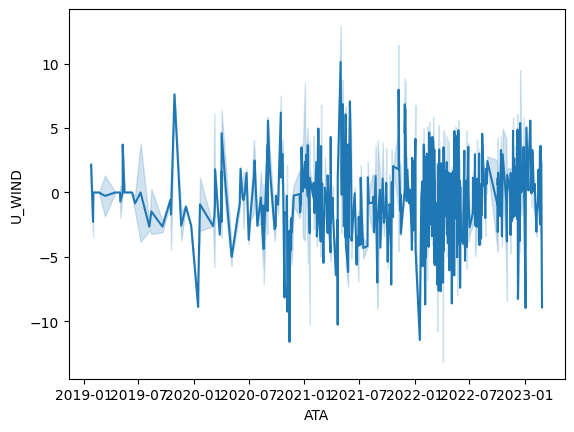

In [ ]:
sns.lineplot(x='ATA', y='U_WIND', data=dup_df[dup_df['ARI_CO'] == 'CN'])

<Axes: xlabel='BTA', ylabel='U_WIND'>

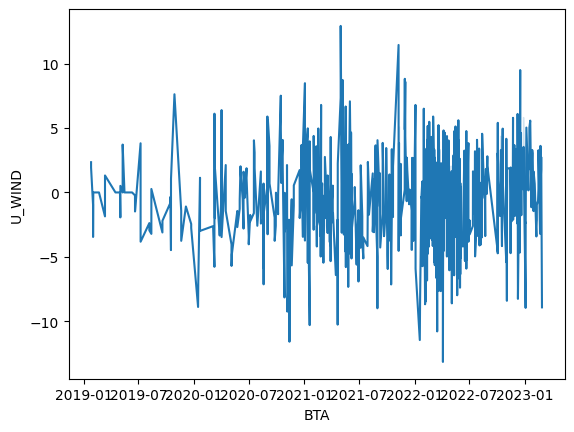

In [ ]:
sns.lineplot(x='BTA', y='U_WIND', data=dup_df[dup_df['ARI_CO'] == 'CN'])

# ATA
- 날짜 데이터

In [10]:
df_train['ATA'] = pd.to_datetime(df_train['ATA'])
df_test['ATA'] = pd.to_datetime(df_test['ATA'])

In [11]:
for df in [df_train, df_test]:
    df['year'] = df['ATA'].dt.year
    df['month_day'] = (df['ATA'].dt.month - 1) * 30 + df['ATA'].dt.day
    df['time'] = df['ATA'].dt.hour * 60 + df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday
    df.drop(columns='ATA', inplace=True)
# year weekday 사용

<Axes: xlabel='month', ylabel='BN'>

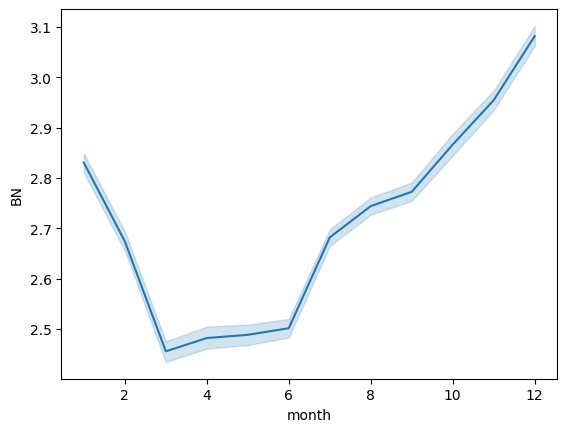

In [ ]:
sns.lineplot(x='month', y='BN', data=df_train)

<Axes: xlabel='month', ylabel='CI_HOUR'>

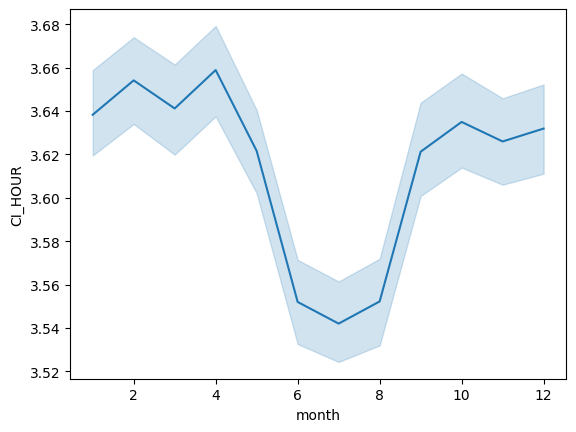

In [ ]:
sns.lineplot(x='month', y='CI_HOUR', data=df_train[df_train['DIST']>0])

<Axes: xlabel='month_day', ylabel='CI_HOUR'>

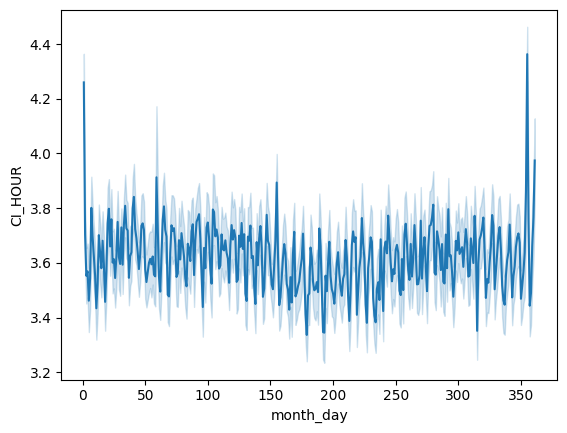

In [ ]:
sns.lineplot(x='month_day', y='CI_HOUR', data=df_train[df_train['DIST']>0])

<Axes: xlabel='year', ylabel='CI_HOUR'>

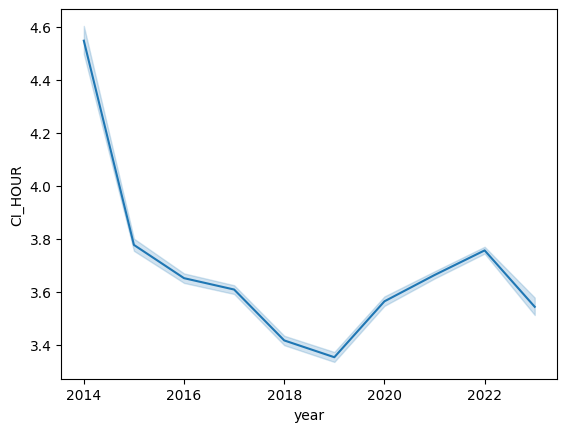

In [ ]:
sns.lineplot(x='year', y='CI_HOUR', data=df_train[df_train['DIST']>0])

<Axes: xlabel='time', ylabel='CI_HOUR'>

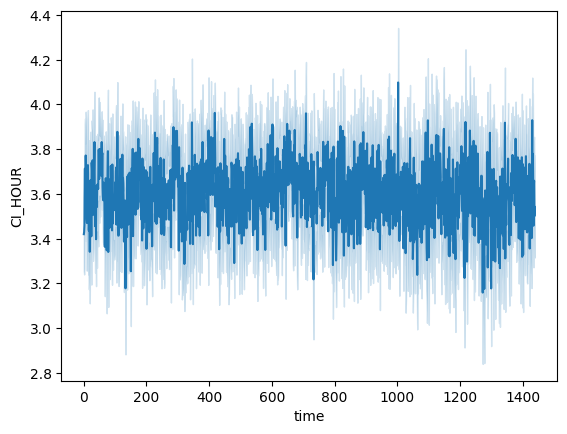

In [ ]:
sns.lineplot(x='time', y='CI_HOUR', data=df_train[df_train['DIST']>0])

<Axes: xlabel='weekday', ylabel='CI_HOUR'>

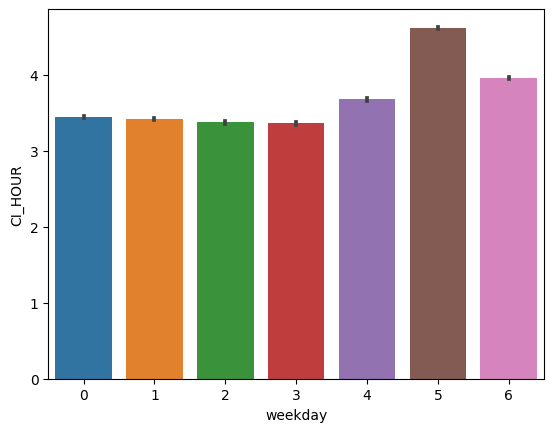

In [ ]:
sns.barplot(x='weekday', y='CI_HOUR', data=df_train[df_train['DIST']>0])

# 그날 있었던 선박

In [ ]:
df_train['ATA_D'] = df_train['ATA'].apply(lambda x: x.floor('d')).astype(str)

In [ ]:
df_train['SHIP_COUNTS'] = [1] * len(df_train)

In [ ]:
port_time_vc = df_train.groupby('ARI_PO')['ATA_D'].value_counts()

In [ ]:
port_time_vc = port_time_vc[port_time_vc > 1]

In [ ]:
port_time_vc

ARI_PO  ATA_D     
AIB7    2022-06-14    14
        2014-09-01    10
        2018-02-27    10
        2016-01-08     9
        2021-03-08     9
                      ..
ZAG4    2023-02-04     2
        2023-02-13     2
        2023-02-19     2
ZME5    2022-03-06     2
        2022-06-03     2
Name: ATA_D, Length: 68175, dtype: int64

In [ ]:
for i, (port, time) in enumerate(tqdm(port_time_vc.index)):
  df_train.loc[(df_train['ARI_PO']==port) & (df_train['ATA_D']==time), 'SHIP_COUNTS'] = [port_time_vc[i]] * port_time_vc[i]

100%|██████████| 68175/68175 [1:08:41<00:00, 16.54it/s]


In [ ]:
df_train['SHIP_COUNTS'].unique()

array([ 21,   1,   9,   4,   5,   3,   8,   6,  14,  15,   2,  12,   7,
        23,  16,  24,  22,  13,  11,  18,  17,  19,  10,  20,  59,  45,
        27,  47,  40,  33,  53,  87,  43,  46,  25,  29,  65,  44,  26,
        32,  54,  42, 224,  66,  31,  50,  60,  35,  36,  71,  62,  56,
        51,  61,  52,  48,  37,  58,  57,  28,  30,  63,  41,  49,  69,
        34,  68,  73,  79,  78,  55,  39,  83,  67,  38,  64])

<Axes: xlabel='SHIP_COUNTS'>

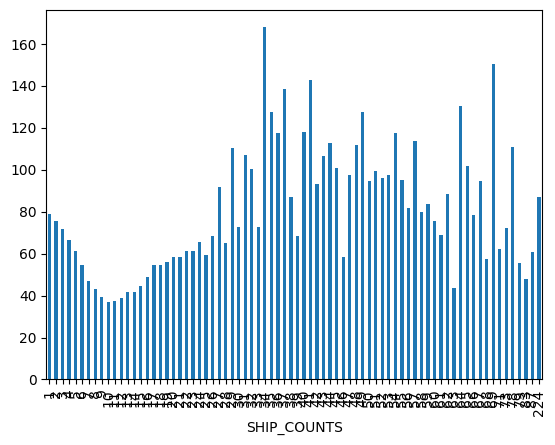

In [ ]:
df_train.groupby('SHIP_COUNTS')['CI_HOUR'].mean().plot(kind='bar')

<Axes: xlabel='ATA', ylabel='CI_HOUR'>

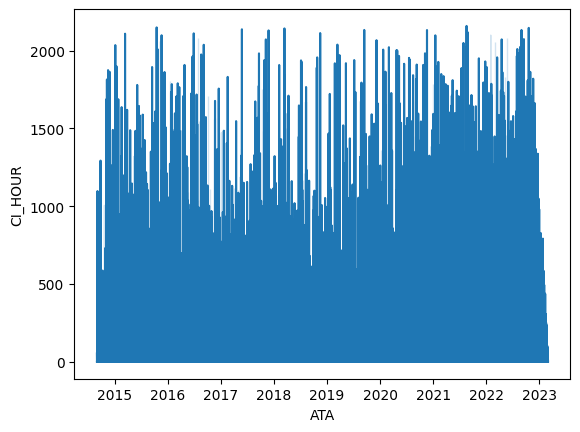

In [ ]:
sns.lineplot(data=df_train[df_train['ARI_CO']=='CN'],x='ATA',y='CI_HOUR')

# DIST

In [ ]:
df_train_dist0 = df_train[df_train['IS_HOUR']==0]
df_train = df_train[df_train['IS_HOUR']==1]

df_test_dist0 = df_test[df_test['DIST']==0]
df_test = df_test[df_test['DIST']>0]

In [ ]:
df_train['DIST'] = np.log1p(df_train['DIST'])
df_test['DIST'] = np.log1p(df_test['DIST'])

<ipython-input-229-a494c33986e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['DIST'] = np.log1p(df_test['DIST'])


# ARI_CO, ARI_PO

- `ARI_CO` : 도착항 앞 2글자
- `ARI_PO` : 도착항 뒤 글자

In [ ]:
df_train['ARI_CO'].unique()

array(['SG', 'AU', 'ID', 'CN', 'QA', 'TT', 'JP', 'TW', 'BR', 'UA', 'MZ',
       'IN', 'RU', 'CA', 'VN', 'LV', 'KR', 'PE', 'MY', 'CL', 'US', 'ZA',
       'FI', 'PH', 'VE'], dtype=object)

In [ ]:
df_train['ARI_PO'].unique()

array(['GIW5', 'UJM2', 'EUC8', 'ZAG4', 'WHH4', 'REJ1', 'JWI3', 'HYG5',
       'NGG6', 'UVK6', 'TDA5', 'KIU2', 'QQW1', 'NQO4', 'IVU2', 'YDP4',
       'VYJ1', 'JEN5', 'FCD5', 'RKA2', 'YRT6', 'EKP8', 'SXD2', 'MIA8',
       'OBZ3', 'XEO4', 'XIU1', 'AIB7', 'MMW5', 'TXO3', 'SPG1', 'PEL6',
       'VFD8', 'PAF4', 'LXJ7', 'XVZ3', 'JTD1', 'FTQ1', 'QGL7', 'EVL6',
       'VXM8', 'NCU8', 'WEY7', 'QTU5', 'TBL3', 'QYY1', 'TMW2', 'IEW6',
       'BGD2', 'AZU6', 'JER7', 'QGN3', 'URE2', 'FFM2', 'UPI6', 'DMD4',
       'KSF1', 'HGH2', 'OZD2', 'PUF3', 'UIR7', 'NNC2', 'WXQ2', 'WAF5',
       'BAZ5', 'QRN3', 'MCG4', 'YFK5', 'TMR7', 'EFG4', 'SLZ5', 'GQJ7',
       'XGX5', 'EVX2', 'CSP6', 'QEA4', 'UEW5', 'BGX4', 'EIA2', 'JGL5',
       'PBQ1', 'HYV6', 'GRQ5', 'CXL1', 'FAV3', 'TYY2', 'CEI5', 'MOC5',
       'URD4', 'DEJ2', 'PDL4', 'JDG8', 'OKM4', 'LHD1', 'PPM2', 'OOV8',
       'XZF6', 'JEA6', 'QXE2', 'DIN2', 'ONW1', 'ZME5', 'RGT8'],
      dtype=object)

In [ ]:
cokeys = df_train.groupby('ARI_CO')['CI_HOUR'].mean().sort_values().index
coidx = [i for i in range(len(cokeys))]
co2idx = dict(zip(cokeys,coidx))

In [ ]:
df_train['ARI_CO'] = df_train['ARI_CO'].apply(lambda x: co2idx[x])
df_test['ARI_CO'] = df_test['ARI_CO'].apply(lambda x: co2idx[x])

<ipython-input-232-4716e587341f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['ARI_CO'] = df_test['ARI_CO'].apply(lambda x: co2idx[x])


In [ ]:
pokeys = df_train.groupby('ARI_PO')['CI_HOUR'].mean().sort_values().index
poidx = [i for i in range(len(pokeys))]
po2idx = dict(zip(pokeys,poidx))

In [ ]:
df_train['ARI_PO'] = df_train['ARI_PO'].apply(lambda x: po2idx[x])
df_test['ARI_PO'] = df_test['ARI_PO'].apply(lambda x: po2idx[x])

<ipython-input-234-fa9dc0b49a2d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['ARI_PO'] = df_test['ARI_PO'].apply(lambda x: po2idx[x])


<Axes: xlabel='ARI_CO'>

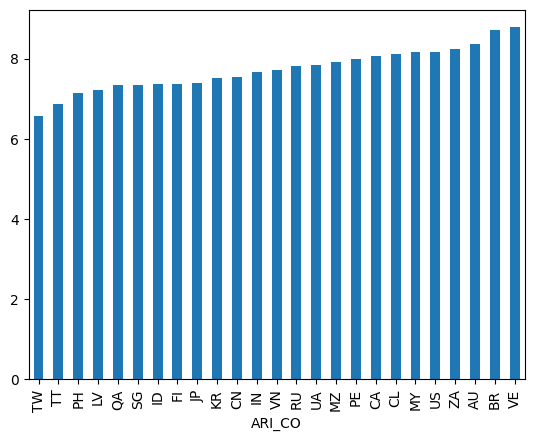

In [ ]:
df_train.groupby("ARI_CO")['CI_HOUR'].mean().sort_values().plot(kind='bar')

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


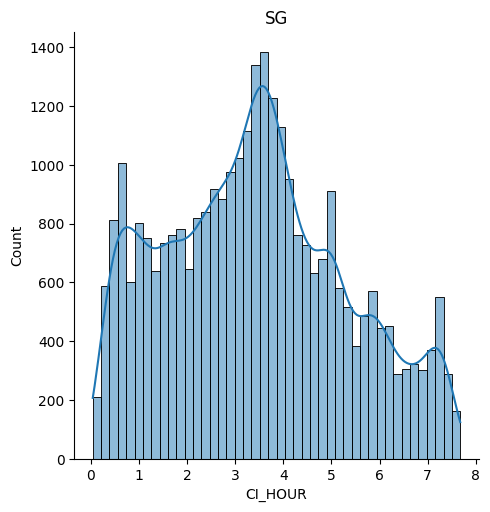

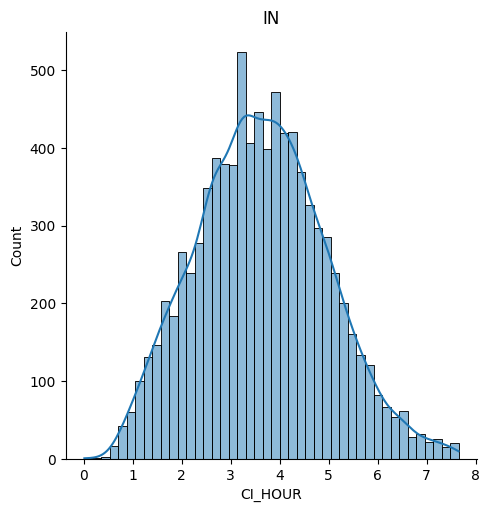

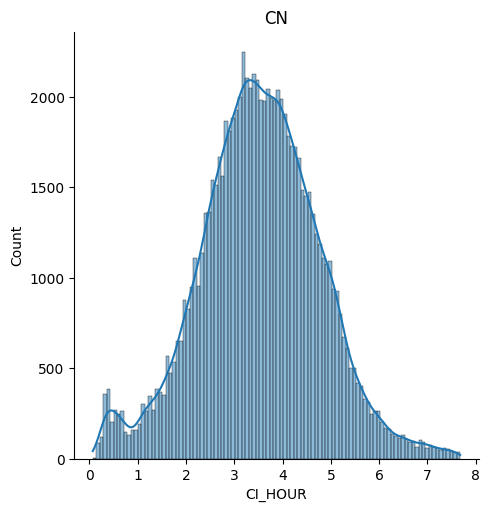

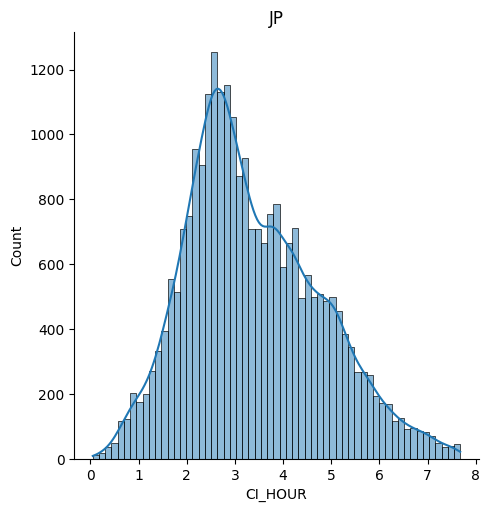

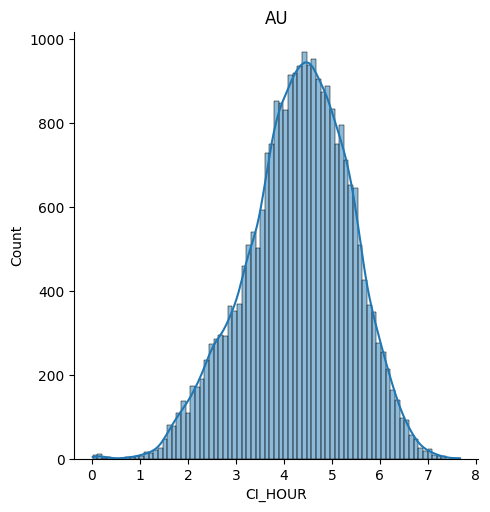

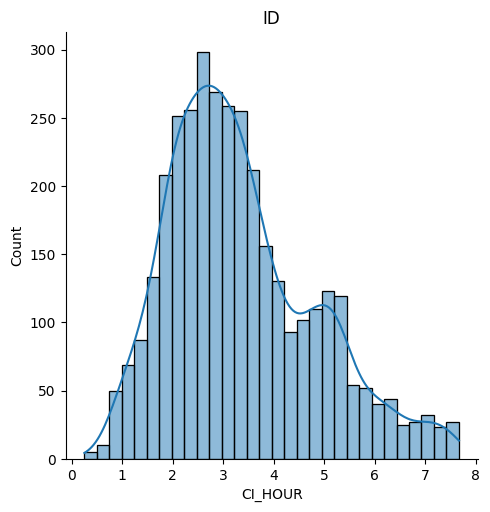

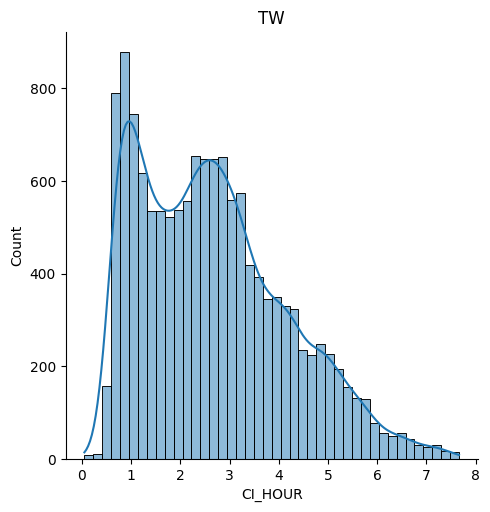

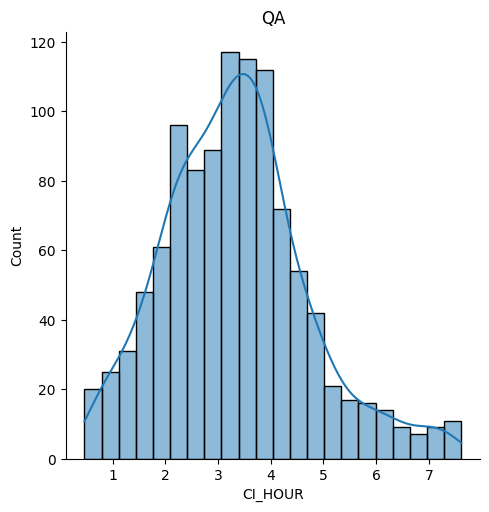

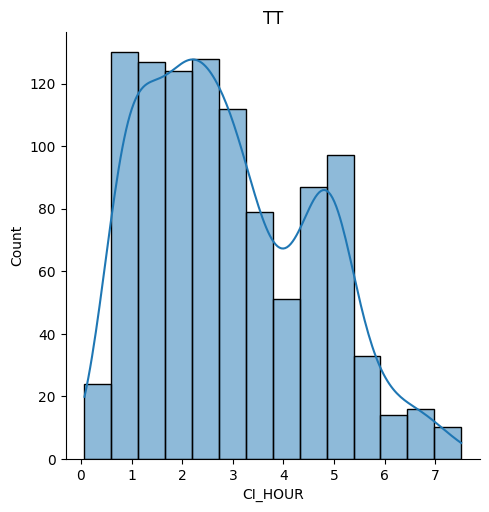

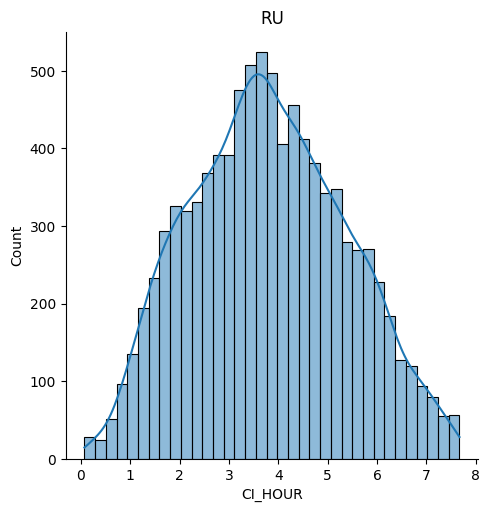

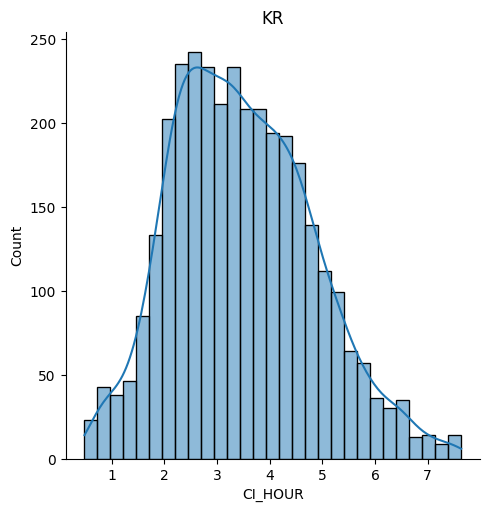

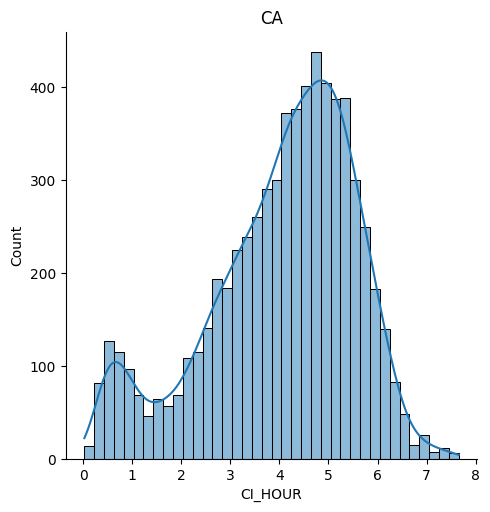

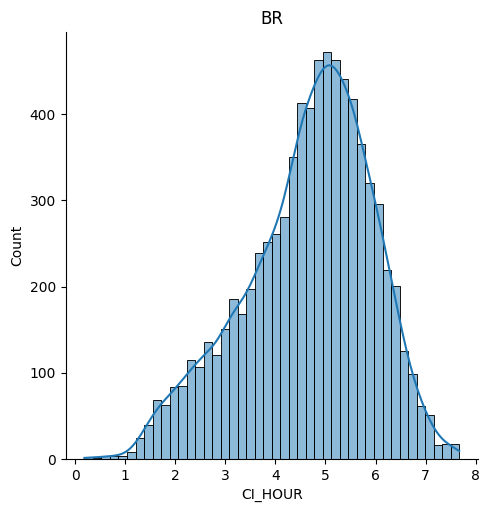

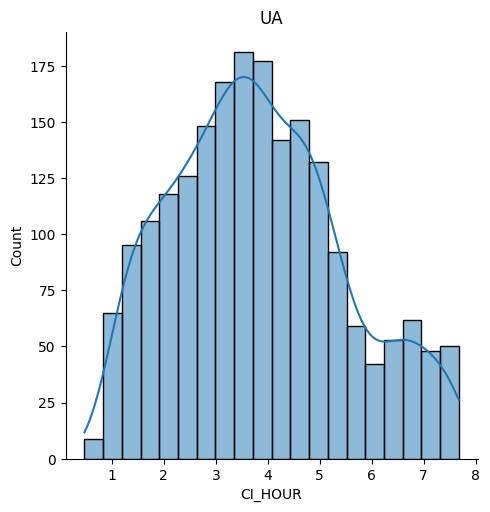

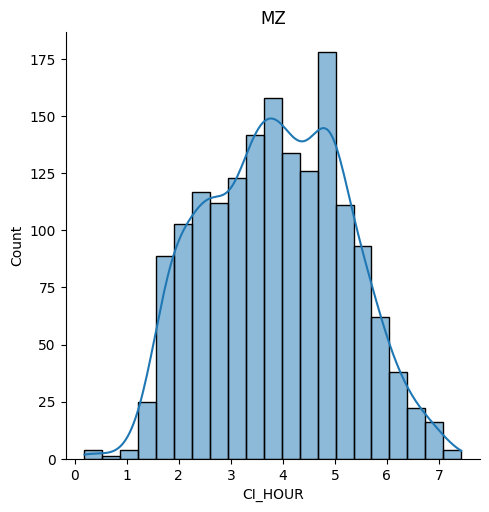

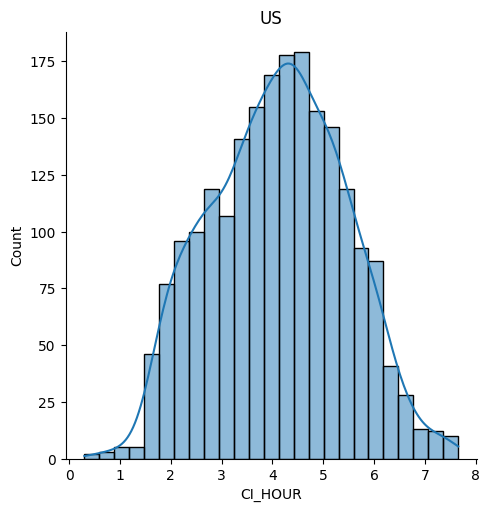

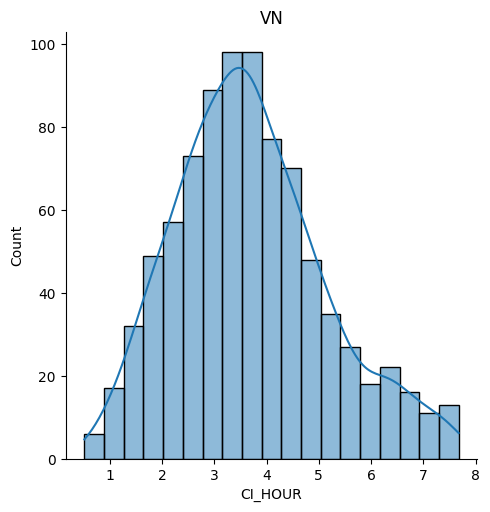

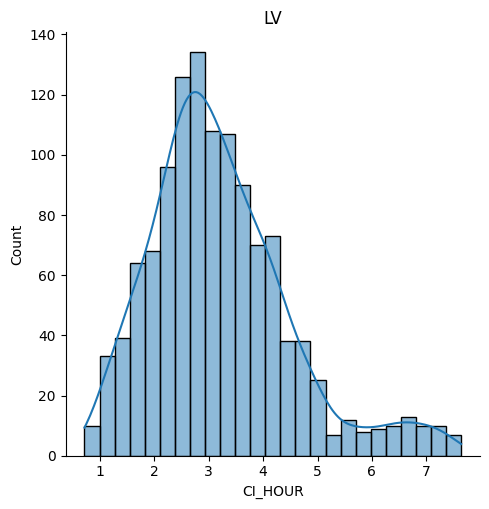

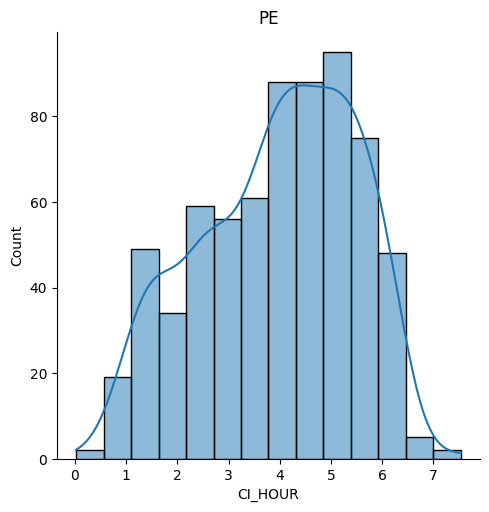

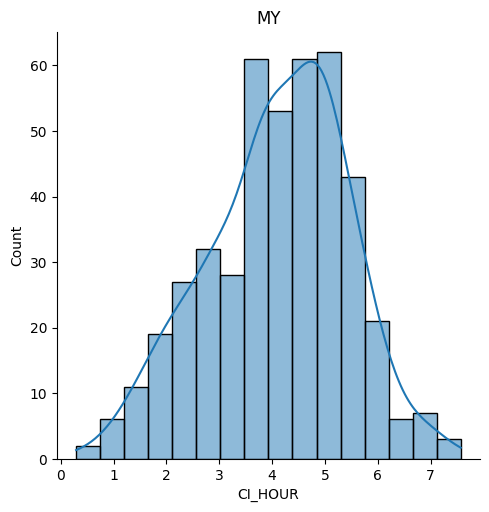

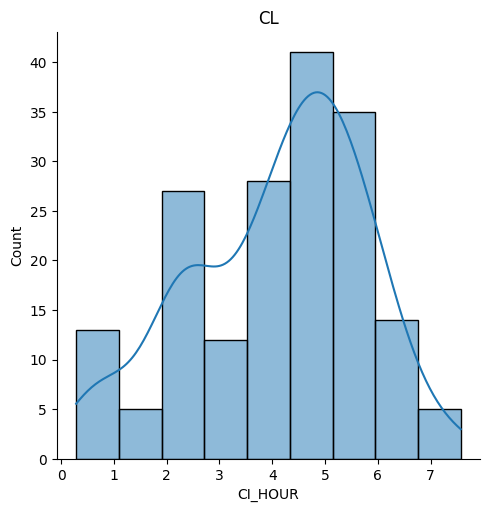

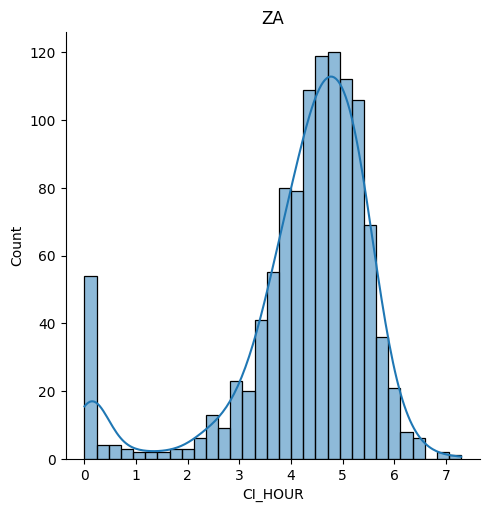

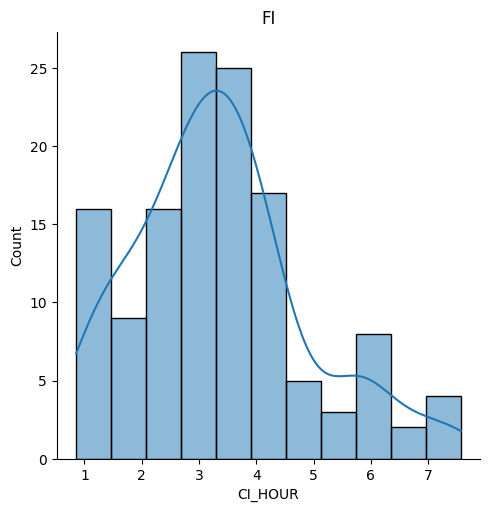

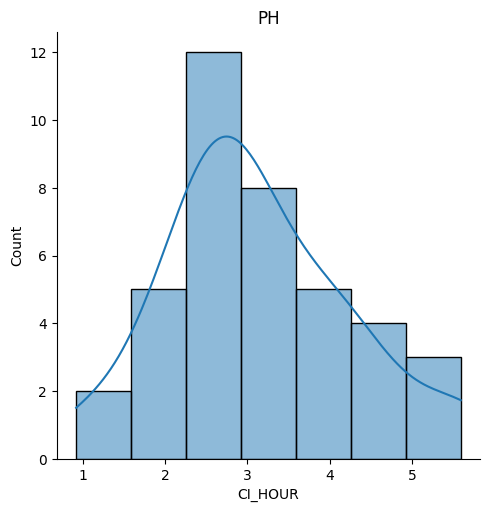

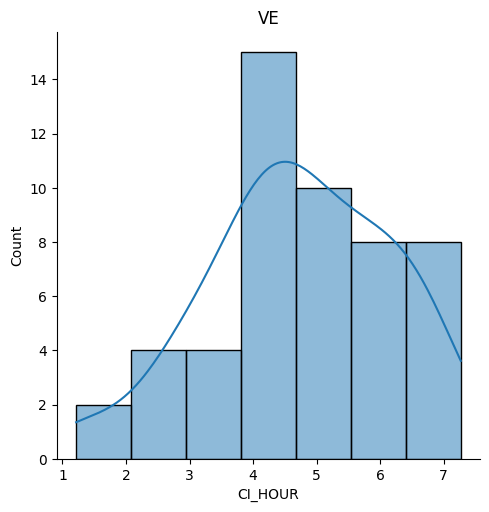

In [ ]:
for country in df_train['ARI_CO'].unique():
  sns.displot(df_train[df_train['ARI_CO']==country]['CI_HOUR'], kde=True)
  plt.title(country)

# SHIP_TYPE_CATEGORY
선종 5대 분류

- Bulk : 선박에서, 다발 짓지 않고 흩어진 채로 쌓은 화물. 석탄·곡물·원유 따위. 순화어는 `무더기 짐'. > 비포장된 화물
- Cargo : 다양한 화물 > 팔레트화 된 화물
- Container : 컨테이너 화물 > 표즌화된 화물 + 글로벌
- Tanker : 주로 액체 또는 가스 화물

*ChatGPT의 대답*

**Bulk Carrier:**

- Purpose: Bulk carriers are designed for the transportation of unpackaged, dry bulk cargo, such as coal, ore, grain, and other commodities. They are typically used for the transportation of large quantities of homogeneous, loose cargo.
- Design: Bulk carriers have large, open cargo holds without individual compartments or containers. The cargo is loaded directly into the holds and discharged by gravity.
- Examples of cargo: Bulk carriers transport bulk cargo in its natural state without packaging.

**General Cargo Ship:**

- Purpose: General cargo ships, also known as "cargo ships," are versatile vessels that can carry a wide range of cargo, including both bulk and packaged goods. They are suitable for transporting various types of cargo in smaller quantities.
- Design: These vessels have a combination of open holds and deck space for containers, palletized cargo, and other general cargo items.
- Examples of cargo: General cargo ships can carry a variety of goods, from machinery and equipment to consumer goods.

**Container Ship:**

- Purpose: Container ships are specifically designed for the transportation of standardized shipping containers. They play a crucial role in the global containerized cargo industry, which includes a wide range of goods.
- Design: Container ships have a series of slots or cells on deck and in their holds to secure and transport standardized containers. These containers can vary in size but are typically 20 or 40 feet in length.
- Examples of cargo: Almost any type of goods can be transported in containers, from electronics and clothing to machinery and industrial equipment.

**Tanker:**

- Purpose: Tankers are designed to transport liquids or gases in bulk. They are commonly used for the transportation of crude oil, petroleum products, chemicals, liquefied natural gas (LNG), and other liquid or gaseous cargo.
- Design: Tankers have specialized tanks or compartments to hold the liquid or gas cargo. These tanks are often equipped with temperature and pressure controls to ensure safe transportation.
- Examples of cargo: Tankers are used to transport liquids and gases, including crude oil, gasoline, chemicals, and liquefied natural gas.

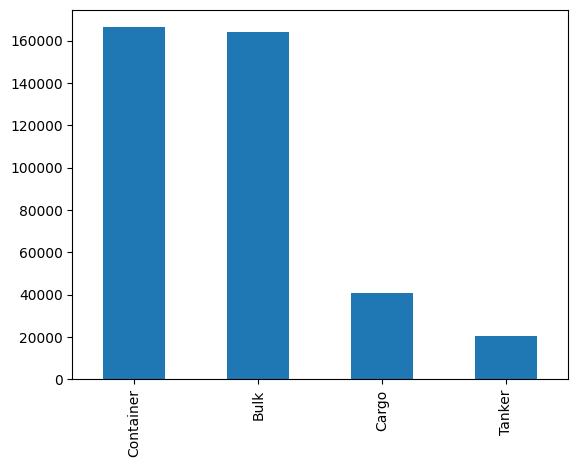

In [ ]:
df_train['SHIP_TYPE_CATEGORY'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
df_train.groupby('SHIP_TYPE_CATEGORY')['CI_HOUR'].mean()

SHIP_TYPE_CATEGORY
Bulk         2.768870
Cargo        2.200390
Container    1.487928
Tanker       2.715088
Name: CI_HOUR, dtype: float64

<Axes: xlabel='CI_HOUR', ylabel='SHIP_TYPE_CATEGORY'>

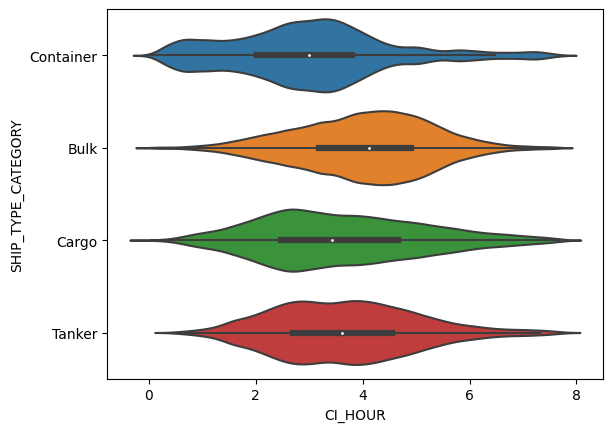

In [ ]:
sns.violinplot(data=df_train[df_train['DIST'] > 0], x='CI_HOUR', y='SHIP_TYPE_CATEGORY')

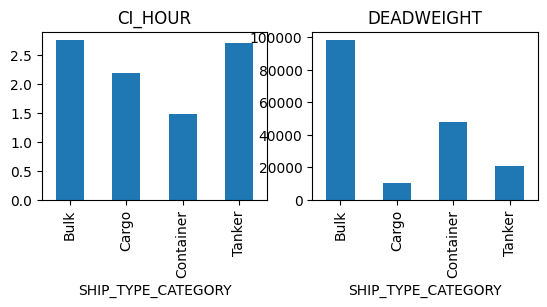

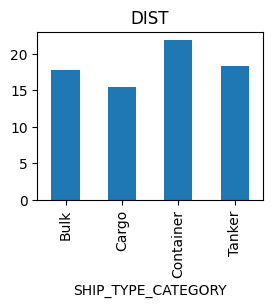

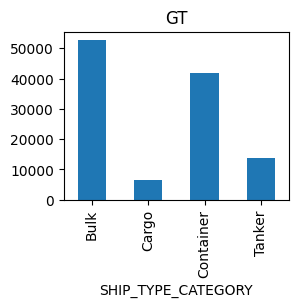

In [ ]:
# MEAN PLOT
plt.subplot(2, 2, 1)
plt.title('CI_HOUR')
df_train.groupby('SHIP_TYPE_CATEGORY')['CI_HOUR'].mean().plot(kind='bar')

plt.subplot(2, 2, 2)
plt.title('DEADWEIGHT')
df_train.groupby('SHIP_TYPE_CATEGORY')['DEADWEIGHT'].mean().plot(kind='bar')
plt.show()

plt.subplot(2, 2, 3)
plt.title('DIST')
df_train.groupby('SHIP_TYPE_CATEGORY')['DIST'].mean().plot(kind='bar')
plt.show()

plt.subplot(2, 2, 4)
plt.title('GT')
df_train.groupby('SHIP_TYPE_CATEGORY')['GT'].mean().plot(kind='bar')
plt.show()

클래스 불균형이 보이지만 `CI_HOUR`의 예측 용도로 사용하기 적합한 것 같다

# SHIPMANAGER

소유주는 무분별하게 다양한 데이터 > 학습에 제거 시도

In [12]:
df_train.drop(columns='SHIPMANAGER', inplace=True)
df_test.drop(columns='SHIPMANAGER', inplace=True)

In [ ]:
df_train[df_train['SHIPMANAGER'] =='PSPJ35']

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,...,BN,ATA_LT,PORT_SIZE,CI_HOUR,IS_HOUR,year,month,day,time,weekday
42,CN,UVK6,Container,11.654212,30.0,25,24200,10.0,10.0,16700,...,NaN,21,0.000520,0.700068,1,2017,9,22,815,4
63,SG,GIW5,Container,0.000000,30.0,10,50000,20.0,10.0,40500,...,NaN,7,0.002615,0.000000,0,2016,11,24,1392,3
65,CN,NGG6,Container,113.425002,40.0,18,69200,20.0,10.0,66500,...,0.000000,16,0.001743,3.937257,1,2019,2,12,537,1
182,CN,EUC8,Container,152.075002,50.0,7,111000,20.0,10.0,94600,...,NaN,21,0.001614,6.486192,1,2016,11,10,828,3
192,IN,JER7,Container,10.821423,30.0,10,50000,20.0,10.0,40500,...,NaN,5,0.000235,3.726824,1,2018,5,1,1412,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391581,CN,QQW1,Container,0.000000,30.0,14,63100,20.0,10.0,54000,...,3.385244,11,0.000595,0.000000,0,2020,10,28,221,2
391590,CN,NCU8,Container,0.000000,30.0,11,50000,20.0,10.0,40400,...,6.071112,21,0.000939,0.000000,0,2019,10,16,807,2
391594,CN,EUC8,Container,58.949785,30.0,23,25600,20.0,10.0,20600,...,6.386702,15,0.001614,2.800731,1,2019,11,13,435,2
391672,CN,EKP8,Container,32.888159,30.0,23,25600,20.0,10.0,20600,...,3.310372,15,0.001660,1.770659,1,2020,9,1,434,1


In [ ]:
df_train['SHIPMANAGER'].value_counts()

PSPJ35    6398
QZFV66    5944
TUZU25    5596
TQXV21    5309
KQMD74    5077
          ... 
UELB43       1
TNZK12       1
HAOA74       1
VAIS15       1
JILK27       1
Name: SHIPMANAGER, Length: 6566, dtype: int64

In [ ]:
df_train['SHIPMANAGER'].str[:2].value_counts()

PS    6859
QZ    6050
RC    5997
TU    5930
TQ    5633
      ... 
EP      18
TF      18
ZM      14
ZV      10
26       1
Name: SHIPMANAGER, Length: 677, dtype: int64

# FLAG

In [ ]:
df_test.loc[df_test['FLAG'] == 'Togo False','FLAG'] = ['Togo'] * 2

<Axes: xlabel='FLAG'>

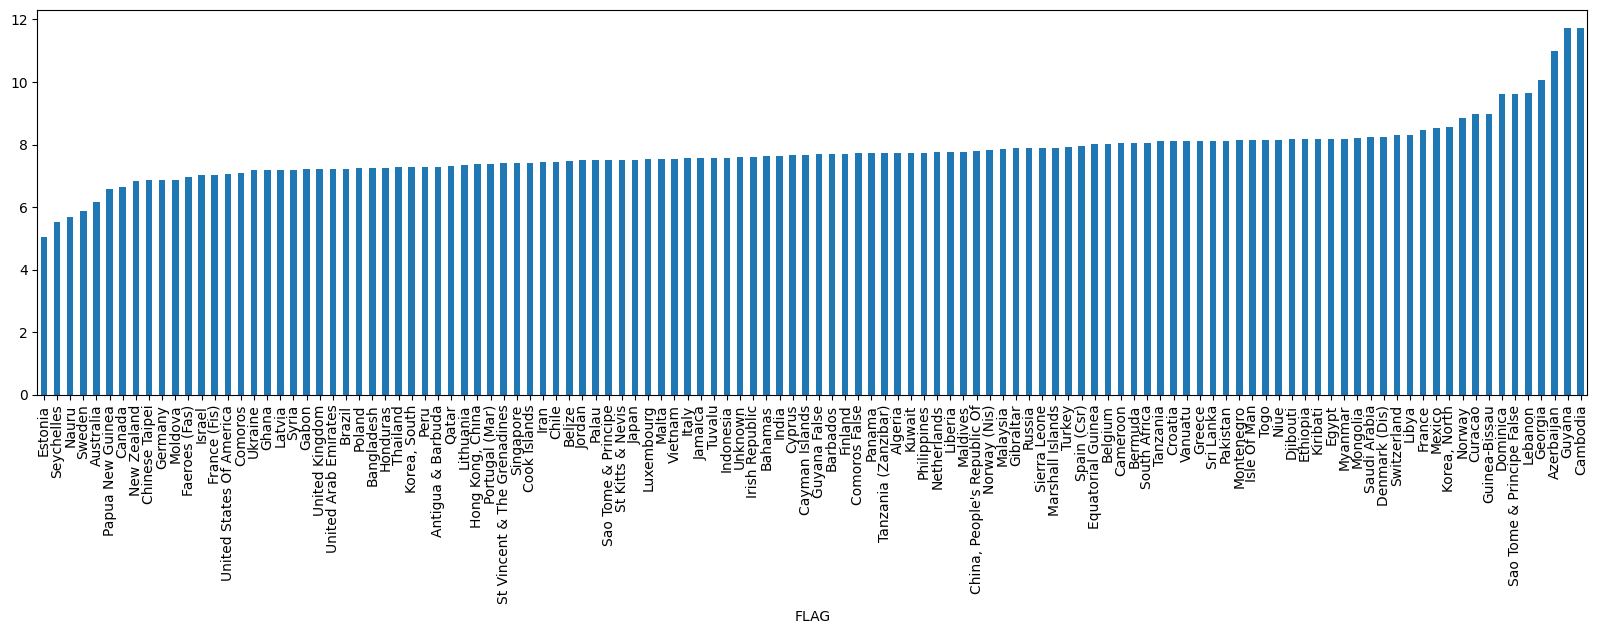

In [ ]:
plt.figure(figsize=(20,5))
df_train.groupby('FLAG')['CI_HOUR'].mean().sort_values().plot(kind='bar')

In [ ]:
ranges = [
    (5.053, 7.444),
    (7.444, 7.939),
    (7.939, 11.715)
]

In [ ]:
flag_label = pd.qcut(df_train.groupby('FLAG')['CI_HOUR'].mean().sort_values(),q=3, labels=[0,1,2])

In [ ]:
for flag in df_test['FLAG'].unique():
  if flag not in df_train['FLAG'].unique():
    flag_label[flag] = 1

In [ ]:
df_train['FLAG'] = df_train['FLAG'].apply(lambda x: flag_label[x])
df_test['FLAG'] = df_test['FLAG'].apply(lambda x: flag_label[x])

<ipython-input-240-45e3905f69c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['FLAG'] = df_test['FLAG'].apply(lambda x: flag_label[x])


<Axes: xlabel='FLAG'>

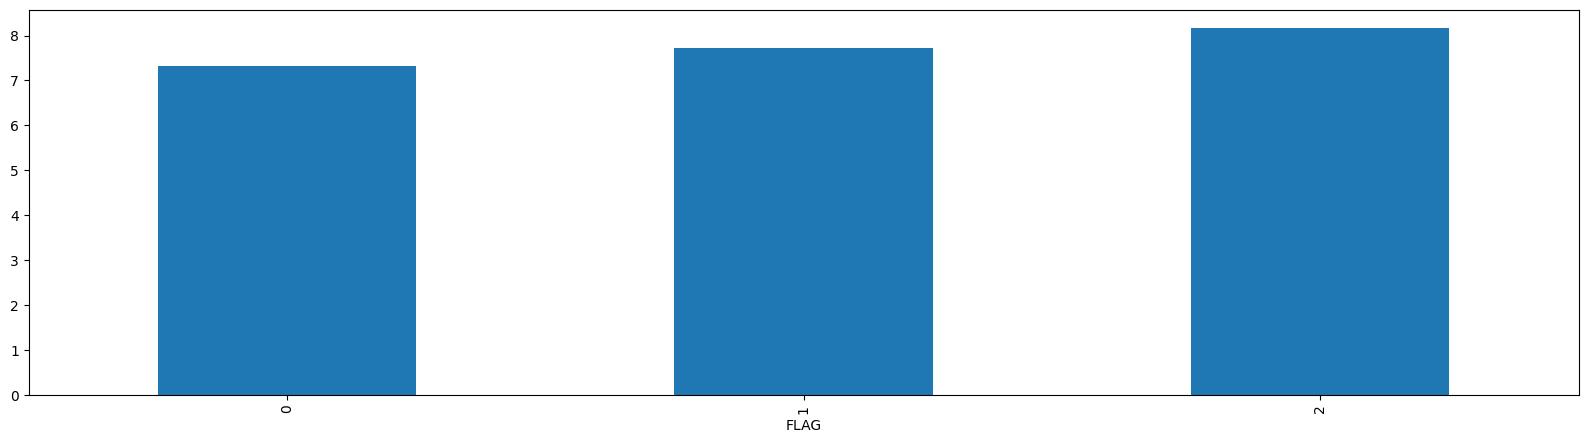

In [ ]:
plt.figure(figsize=(20,5))
df_train.groupby('FLAG')['CI_HOUR'].mean().sort_values().plot(kind='bar')

# 선박 정보

In [13]:
df_ship = df_train[['SHIP_TYPE_CATEGORY','BREADTH','BUILT','DEADWEIGHT','DEPTH','DRAUGHT','GT','LENGTH','CI_HOUR']]

In [ ]:
def plot_by_cat(feature):
  fig, axes = plt.subplots(2, 2, figsize=(10,10))

  axes[0,0].set_title('Bulk')
  axes[0,1].set_title('Cargo')
  axes[1,0].set_title('Container')
  axes[1,1].set_title('Tanker')
  sns.histplot(df_ship[df_ship['SHIP_TYPE_CATEGORY']=='Bulk'][feature], ax=axes[0,0])
  sns.histplot(df_ship[df_ship['SHIP_TYPE_CATEGORY']=='Cargo'][feature], ax=axes[0,1])
  sns.histplot(df_ship[df_ship['SHIP_TYPE_CATEGORY']=='Container'][feature], ax=axes[1,0])
  sns.histplot(df_ship[df_ship['SHIP_TYPE_CATEGORY']=='Tanker'][feature], ax=axes[1,1])

  plt.show()

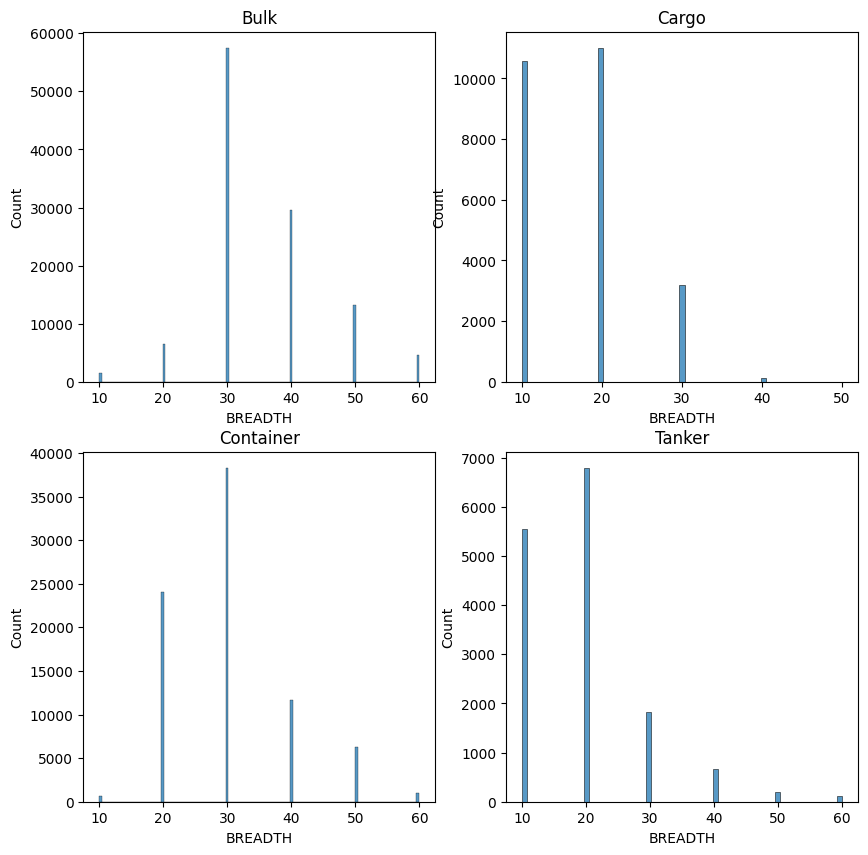

In [ ]:
plot_by_cat('BREADTH')

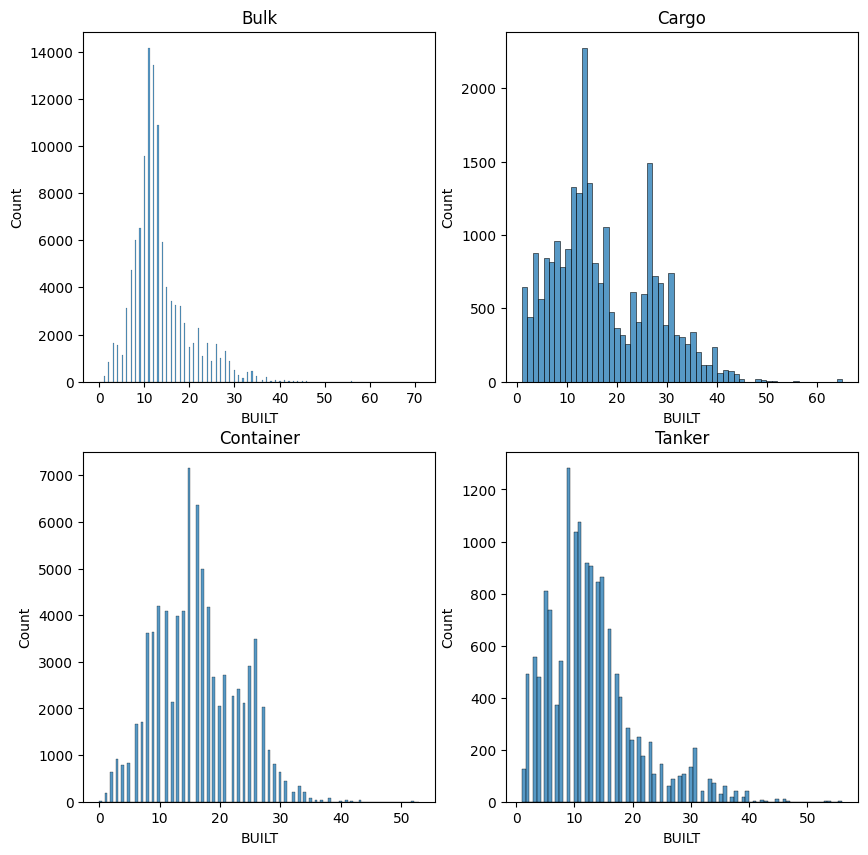

In [ ]:
plot_by_cat('BUILT')

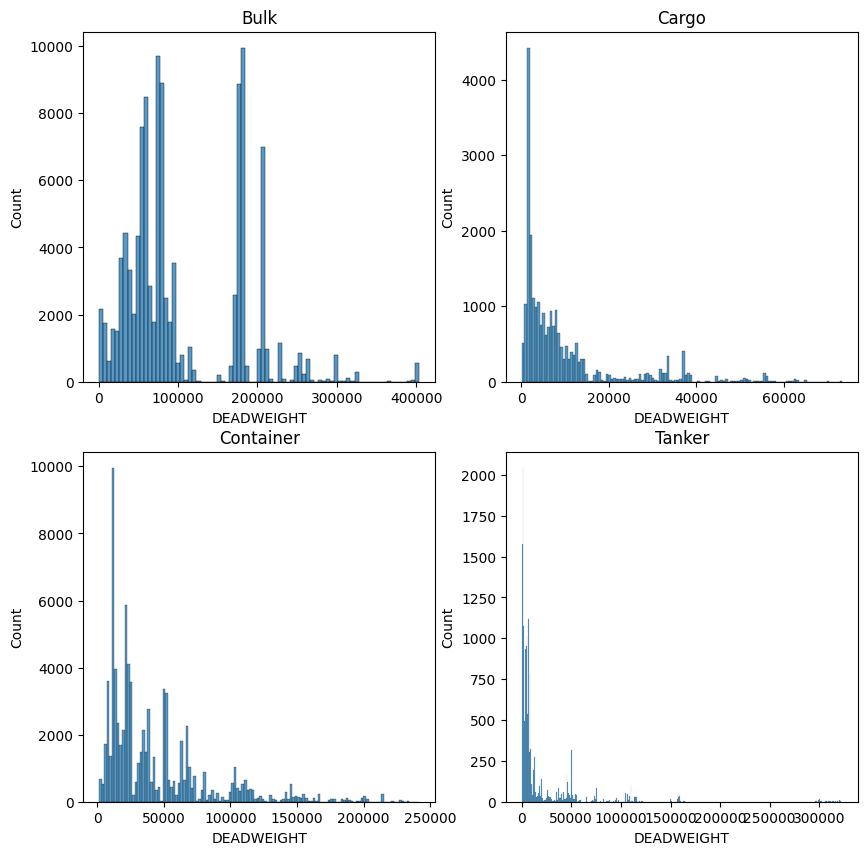

In [ ]:
plot_by_cat('DEADWEIGHT')

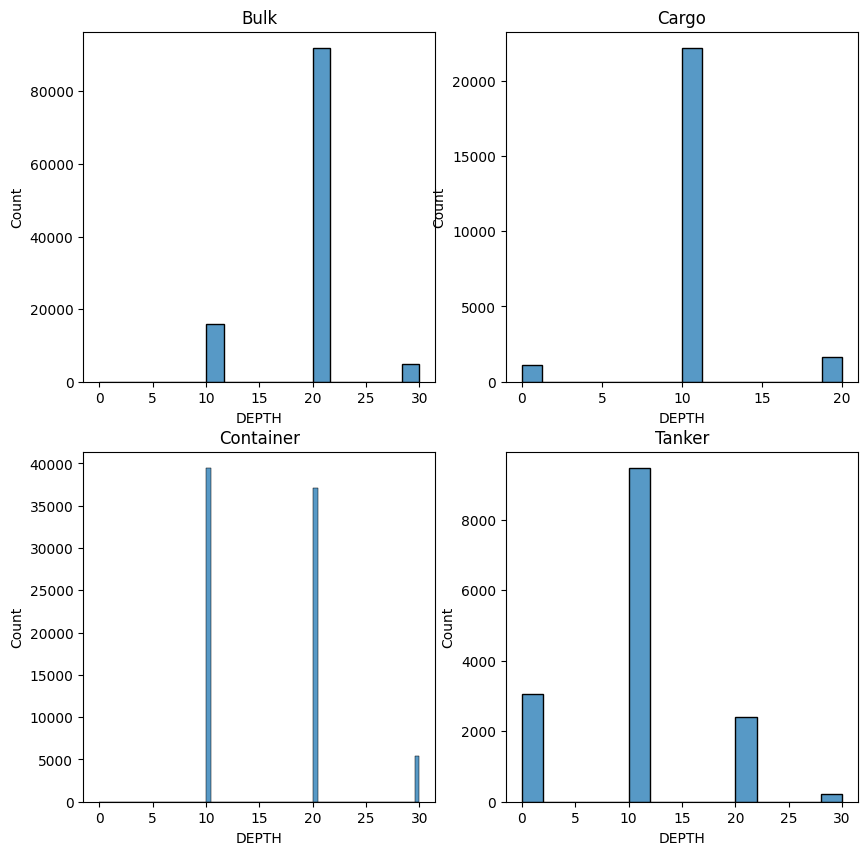

In [ ]:
plot_by_cat('DEPTH')

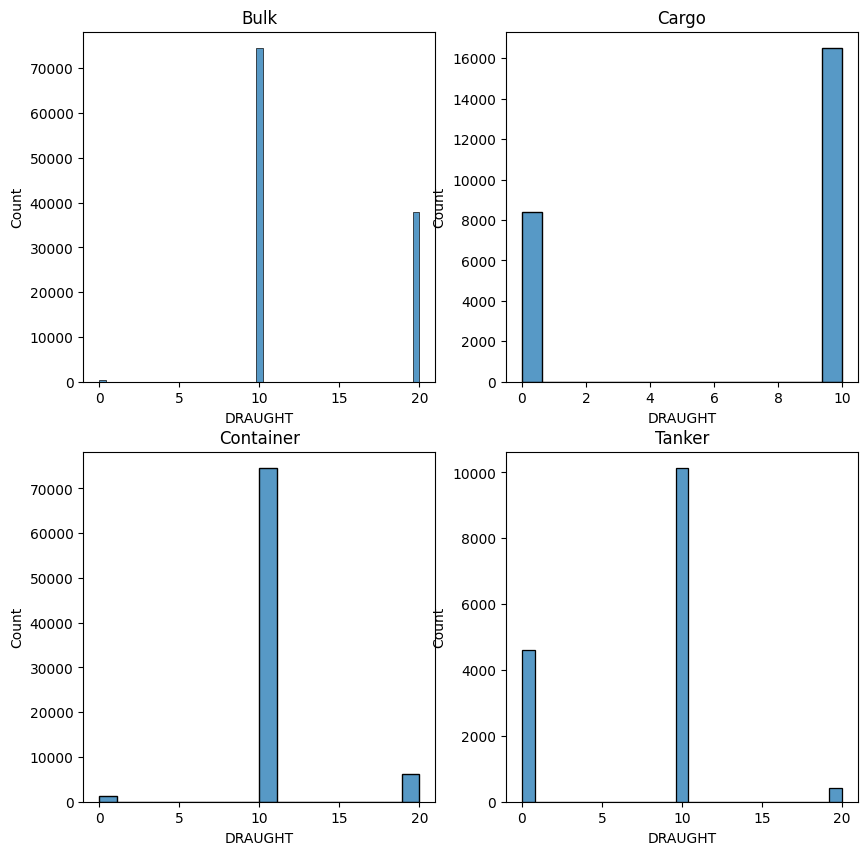

In [ ]:
plot_by_cat('DRAUGHT')

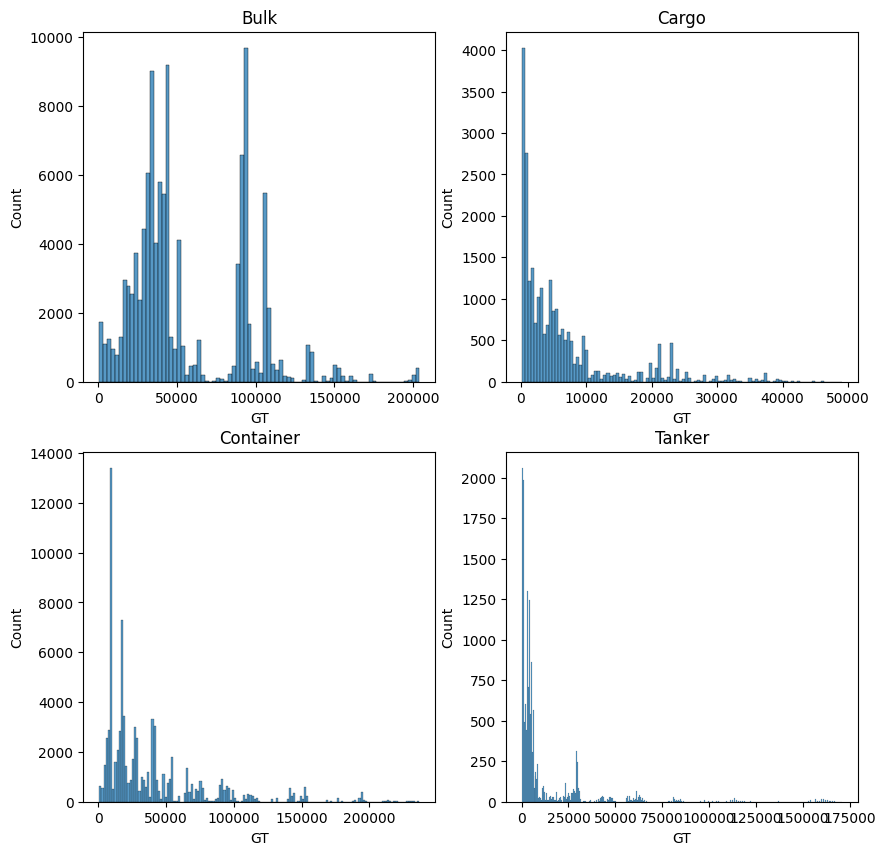

In [ ]:
plot_by_cat('GT')

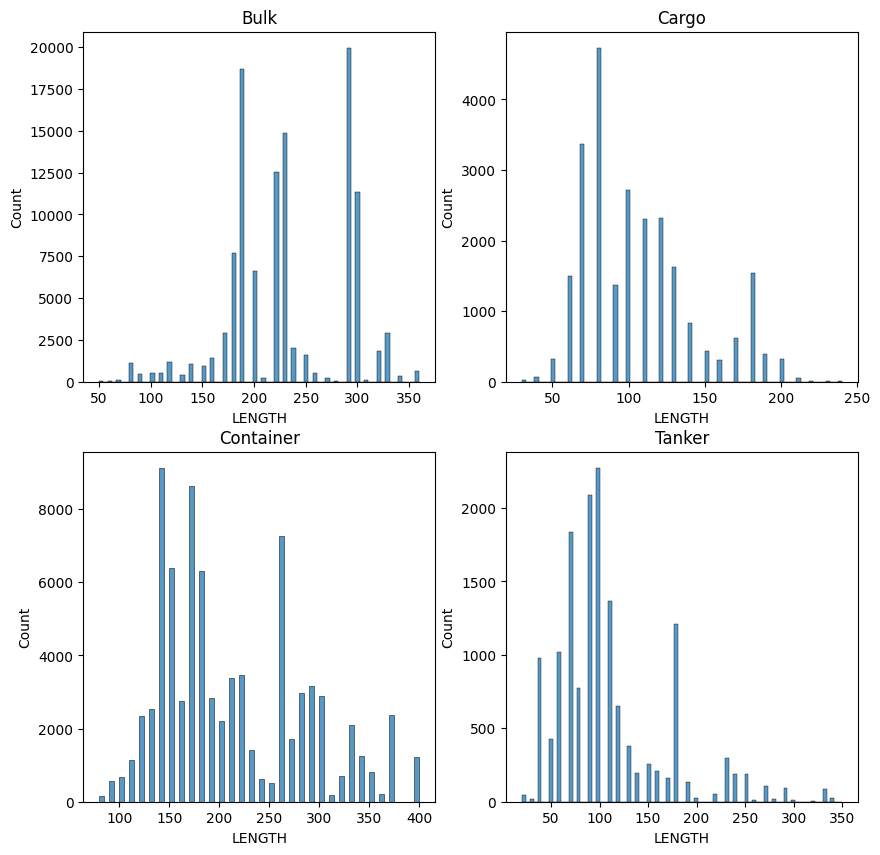

In [ ]:
plot_by_cat('LENGTH')

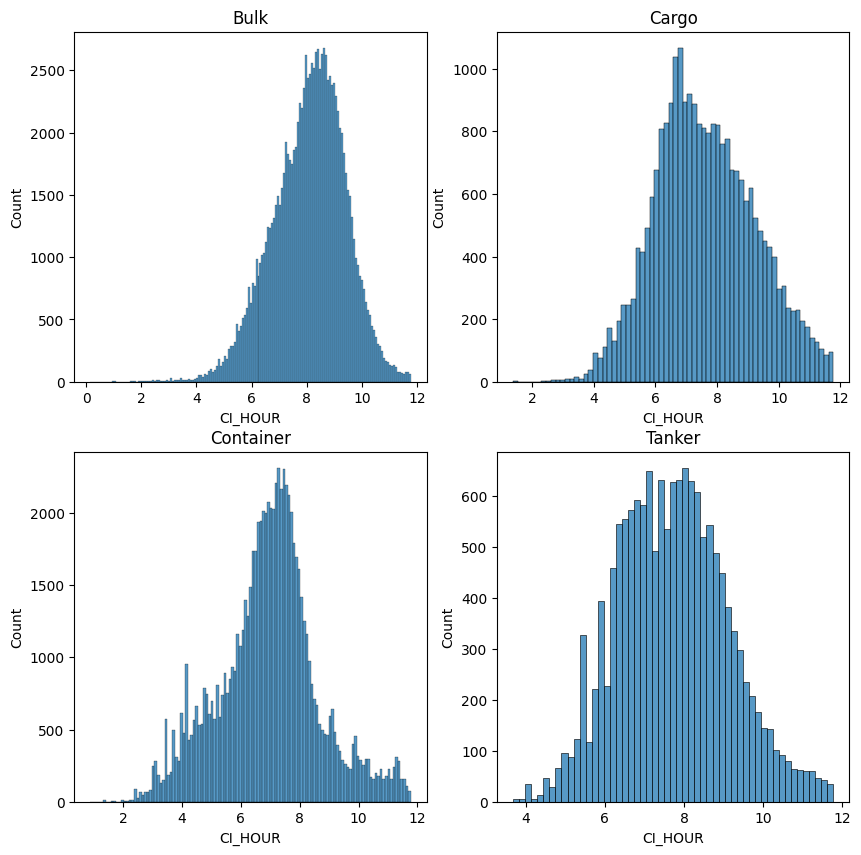

In [ ]:
plot_by_cat('CI_HOUR')

<ipython-input-242-629eab8ed4b1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_ship[df_ship['SHIP_TYPE_CATEGORY']=='Tanker'].corr('spearman'), annot=True, fmt='f')


<Axes: >

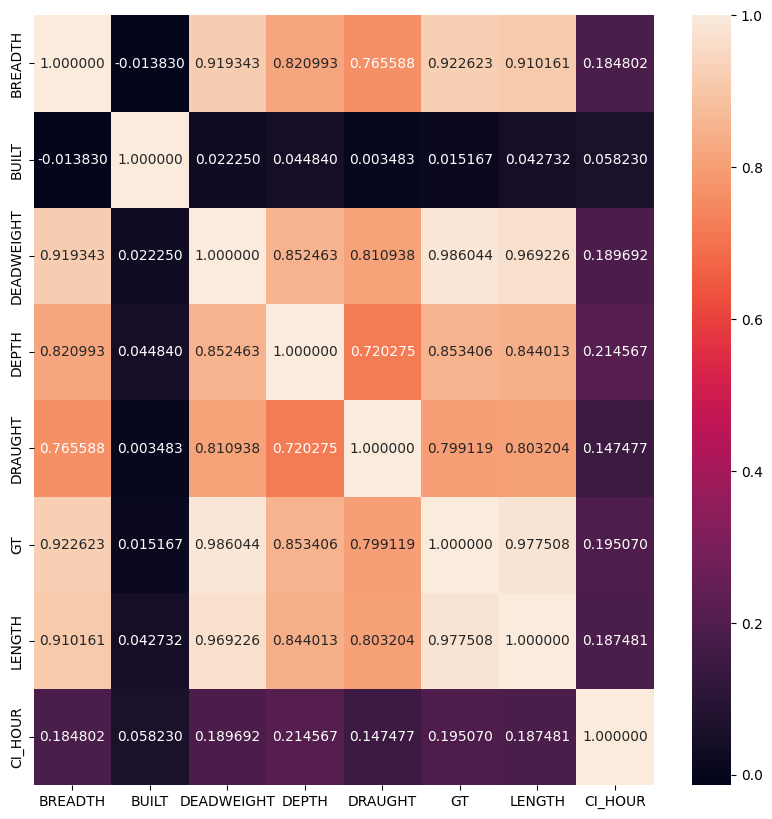

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df_ship[df_ship['SHIP_TYPE_CATEGORY']=='Tanker'].corr('spearman'), annot=True, fmt='f')

- BUILT 제외하고 전부 PCA로 하나의 칼럼으로 도출


In [15]:
from sklearn.decomposition import PCA

columns = ['BREADTH','DEADWEIGHT','GT','LENGTH','DEPTH','DRAUGHT']

pca = PCA(n_components=1)

train_pca = pca.fit_transform(df_train[columns])
test_pca = pca.transform(df_test[columns])

실제 사용할 데이터에 적용

In [16]:
df_train['SHIP'] = train_pca
df_test['SHIP'] = test_pca

df_train.drop(columns=columns, inplace=True)
df_test.drop(columns=columns, inplace=True)

# 결측치 처리

- `U_WIND`, `V_WIND`, `BN`, `AIR_TEMPERATURE` 에 다수의 결측값 확인
- 기상 정보 분석에서 봤듯이, 정확한 값을 위해 `CI_HOUR` == 0 인 값으로 예측
- `U_WIND` 와 `V_WIND`로 WIND_DIRECTION을 예측할 수 있음.
- RandomForest로 결측값 예측

<Axes: >

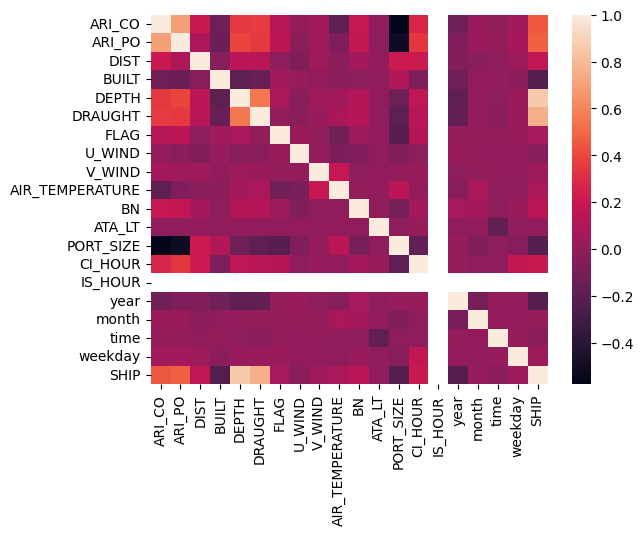

In [ ]:
sns.heatmap(df_train.drop(columns=['SHIP_TYPE_CATEGORY']).corr('spearman'))

In [17]:
nan_train = df_train[['ARI_CO','ARI_PO', 'month_day','time','weekday','U_WIND', 'V_WIND', 'BN', 'AIR_TEMPERATURE']]

In [18]:
trainset = nan_train[~nan_train['AIR_TEMPERATURE'].isna()].copy()
validset = df_train[df_train['AIR_TEMPERATURE'].isna()][['ARI_CO','ARI_PO','month_day','time','weekday','U_WIND', 'V_WIND', 'BN', 'AIR_TEMPERATURE']].copy()
testset = df_test[df_test['AIR_TEMPERATURE'].isna()][['ARI_CO','ARI_PO','month_day','time','weekday','U_WIND', 'V_WIND', 'BN', 'AIR_TEMPERATURE']].copy()

In [19]:
le = LabelEncoder()

for col in ['ARI_CO','ARI_PO']:
  print(col)
  le.fit(df_train[col])
  trainset[col] = le.transform(trainset[col])
  validset[col] = le.transform(validset[col])
  testset[col] = le.transform(testset[col])

ARI_CO
ARI_PO


In [20]:
X_train = trainset.iloc[:,:5]
y_train = trainset.iloc[:,5:]

In [21]:
nan_model = RandomForestRegressor()

nan_model.fit(X_train, y_train)

RandomForestRegressor()

In [22]:
nan_model.score(X_train, y_train)

0.918377714674063

In [23]:
validset.iloc[:,5:] = nan_model.predict(validset.iloc[:,:5])

testset.iloc[:,5:] = nan_model.predict(testset.iloc[:,:5])

In [24]:
df_train.loc[validset.index,['U_WIND', 'V_WIND', 'BN', 'AIR_TEMPERATURE']] = validset.iloc[:,5:]
df_test.loc[testset.index,['U_WIND', 'V_WIND', 'BN', 'AIR_TEMPERATURE']] = testset.iloc[:,5:]

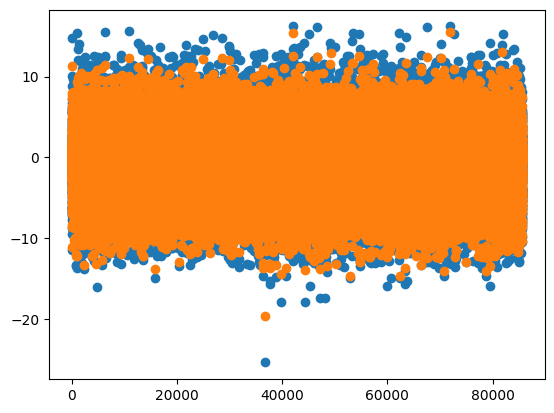

In [ ]:
plt.scatter(range(len(y_train['U_WIND'])), y_train['U_WIND'])
plt.scatter(range(len(y_train['U_WIND'])), nan_model.predict(X_train)[:,0])

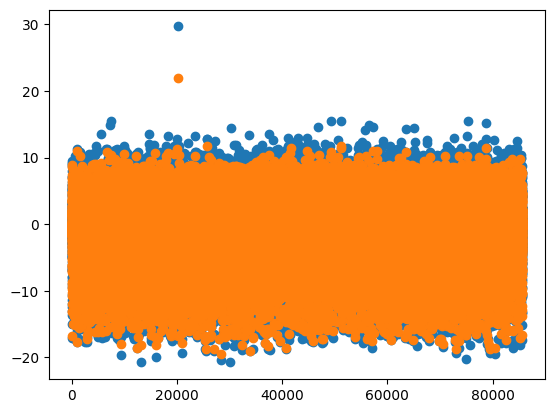

In [ ]:
plt.scatter(range(len(y_train['V_WIND'])), y_train['V_WIND'])
plt.scatter(range(len(y_train['V_WIND'])), nan_model.predict(X_train)[:,1])

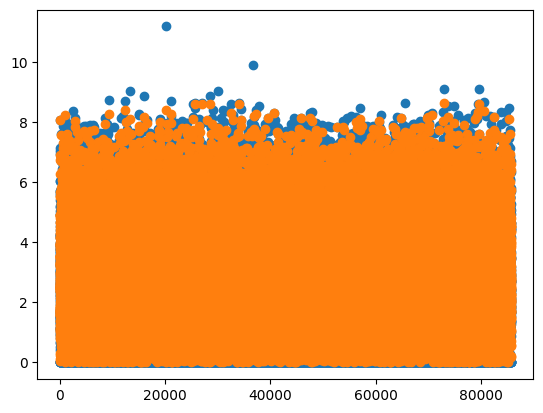

In [ ]:
plt.scatter(range(len(y_train['BN'])), y_train['BN'])
plt.scatter(range(len(y_train['BN'])), nan_model.predict(X_train)[:,2])

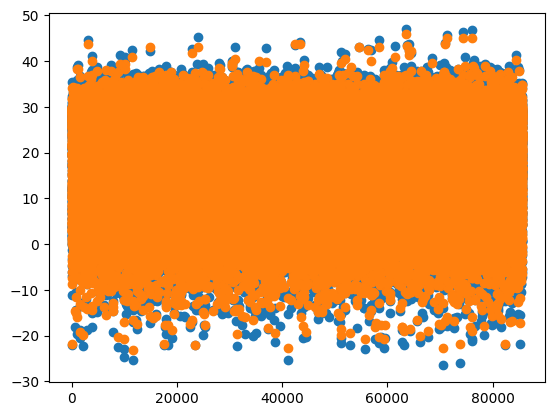

In [ ]:
plt.scatter(range(len(y_train['AIR_TEMPERATURE'])), y_train['AIR_TEMPERATURE'])
plt.scatter(range(len(y_train['AIR_TEMPERATURE'])), nan_model.predict(X_train)[:,3])

In [ ]:
# 나머지는 1개의 결측값 밖에 없으므로 drop
df_train = df_train.dropna()

In [25]:
df_train.isna().sum()

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
BUILT                 0
FLAG                  0
U_WIND                0
V_WIND                0
AIR_TEMPERATURE       0
BN                    0
ATA_LT                0
PORT_SIZE             0
CI_HOUR               0
year                  0
month_day             0
time                  0
weekday               0
SHIP                  0
dtype: int64

In [ ]:
def calculate_wind_speed_and_direction(u_vector, v_vector):
    wind_speed = np.sqrt(u_vector**2 + v_vector**2)
    wind_direction_rad = np.arctan2(v_vector, u_vector)
    wind_direction_deg = np.degrees(wind_direction_rad)

    wind_direction_deg = (wind_direction_deg + 360) % 360

    return wind_speed, wind_direction_deg

In [ ]:
train_speed, train_direction = calculate_wind_speed_and_direction(df_train['U_WIND'], df_train['V_WIND'])
test_speed, test_direction = calculate_wind_speed_and_direction(df_test['U_WIND'], df_test['V_WIND'])

In [ ]:
df_train['DIRECTION'] = (train_direction//90).astype(int)
df_test['DIRECTION'] = (test_direction//90).astype(int)

df_train.drop(columns=['U_WIND','V_WIND'], inplace=True)
df_test.drop(columns=['U_WIND','V_WIND'], inplace=True)

# 이상치

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN

data = df_train['CI_HOUR'].values.reshape(-1,1)

# Z-Score 기반 이상치 제거
z_scores = (data - np.mean(data)) / np.std(data)
threshold = 1.96
outliers_zscore = np.abs(z_scores) > threshold
data_cleaned_zscore = data[~outliers_zscore]

# IQR을 이용한 이상치 제거
q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
iqr = q75 - q25
cut_off = 1.5 * iqr
lower, upper = q25 - cut_off, q75 + cut_off
outliers_iqr = (data < lower) | (data > upper)
data_cleaned_iqr = data[~outliers_iqr]

# Isolation Forest를 이용한 이상치 제거
iso_forest = IsolationForest(contamination=0.05)
outliers_iso = iso_forest.fit_predict(data)
data_cleaned_iso = data[outliers_iso == 1]

# DBSCAN을 이용한 이상치 제거
# scaler = RobustScaler()
# data_scaled = scaler.fit_transform(data)
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# outliers_dbscan = dbscan.fit_predict(data_scaled)
# data_cleaned_dbscan = data[outliers_dbscan != -1]

# 출력
# print("Original Data:", data.flatten())
# print("Z-Score Cleaned Data:", data_cleaned_zscore.flatten())
# print("IQR Cleaned Data:", data_cleaned_iqr.flatten())
# print("Isolation Forest Cleaned Data:", data_cleaned_iso.flatten())
# print("DBSCAN Cleaned Data:", data_cleaned_dbscan.flatten())

In [ ]:
print(data.shape, data_cleaned_zscore.shape, data_cleaned_iqr.shape, data_cleaned_iso.shape)

(234674, 1) (221511,) (234514,) (222982, 1)


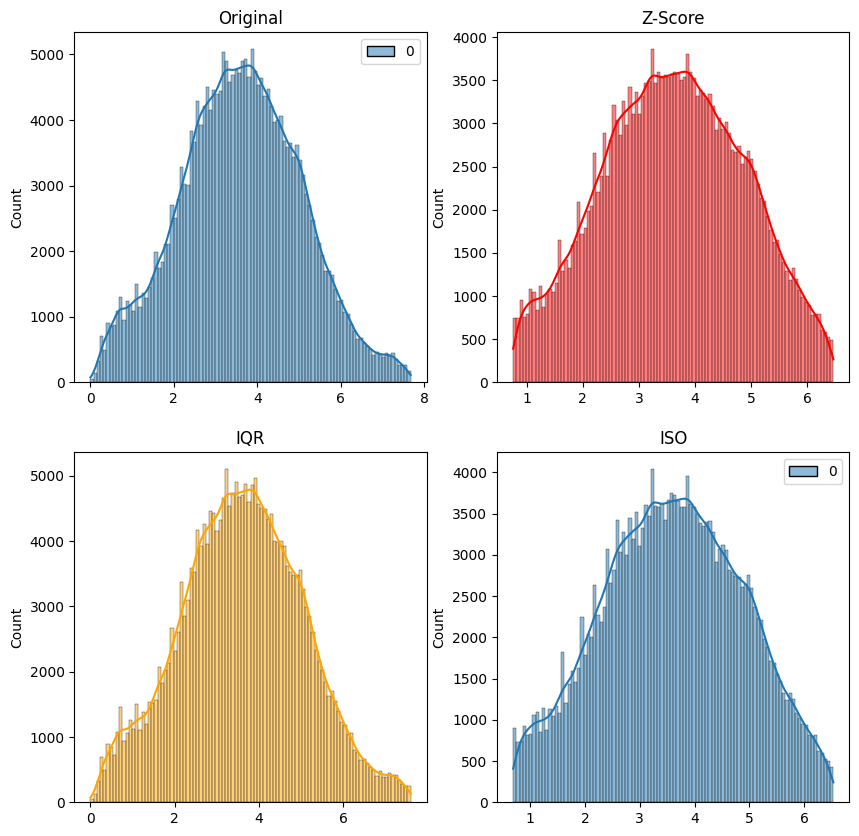

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

plt.subplot(2, 2, 1)
sns.histplot(data, bins=100, kde=True, color='skyblue')
plt.title('Original')

plt.subplot(2, 2, 2)
sns.histplot(data_cleaned_zscore, bins=100, kde=True, color='red')
plt.title('Z-Score')

plt.subplot(2, 2, 3)
sns.histplot(data_cleaned_iqr, bins=100, kde=True, color='orange')
plt.title('IQR')

plt.subplot(2, 2, 4)
sns.histplot(data_cleaned_iso, bins=100, kde=True, color='brown')
plt.title('ISO')

plt.show()

In [ ]:
df_train = df_train[~outliers_zscore]

In [ ]:
df_train = df_train[outliers_iso==1]

In [ ]:
df_train = df_train[~outliers_iqr]

# 연습노트

In [ ]:
df_train.drop(columns='ATA_LT',inplace=True)
df_test.drop(columns='ATA_LT',inplace=True)

<ipython-input-256-357529e54d2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns='ATA_LT',inplace=True)


# Label Encoding

- 범주형 데이터 인코딩

In [26]:
df_train = df_train.copy()
df_test = df_test.copy()

In [ ]:
# label encoding
# label_cols =  ['ARI_CO','ARI_PO', 'SHIP_TYPE_CATEGORY', 'FLAG']
label_cols =  ['SHIP_TYPE_CATEGORY']

for col in tqdm(label_cols, desc="Encoding features"):
  le = LabelEncoder()
  le = le.fit(df_train[col])
  df_train[col] = le.transform(df_train[col])

  for label in np.unique(df_test[col]):
    if label not in le.classes_:
      le.classes_ = np.append(le.classes_, label)
  df_test[col] = le.transform(df_test[col])

Encoding features: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


SHIPTYPECATEGORY를 기준으로 모델 나누기

In [ ]:
df_train0 = df_train[df_train['SHIP_TYPE_CATEGORY']==0]
df_test0 = df_test[df_test['SHIP_TYPE_CATEGORY']==0]

df_train1 = df_train[df_train['SHIP_TYPE_CATEGORY']==1]
df_test1 = df_test[df_test['SHIP_TYPE_CATEGORY']==1]

df_train2 = df_train[df_train['SHIP_TYPE_CATEGORY']==2]
df_test2 = df_test[df_test['SHIP_TYPE_CATEGORY']==2]

df_train3 = df_train[df_train['SHIP_TYPE_CATEGORY']==3]
df_test3 = df_test[df_test['SHIP_TYPE_CATEGORY']==3]

# 모델링

## CLF 후 REG 하는 모델

In [ ]:
numerical_cols = ['DIST','BREADTH', 'BUILT','AIR_TEMPERATURE','DEADWEIGHT', 'DEPTH','DRAUGHT','U_WIND','V_WIND','BN','ATA_LT','PORT_SIZE', 'time']
categorical_cols = ['ARI','SHIP_TYPE_CATEGORY','SHIPMANAGER','FLAG', 'year', 'weekday', 'day', 'month']

In [ ]:
X_train = df_train.drop(columns=['CI_HOUR', 'IS_HOUR'])
y_train_clf = df_train['IS_HOUR']
X_test = df_test.copy()

In [ ]:
sc = MinMaxScaler()

X_train[numerical_cols] = sc.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = sc.transform(X_test[numerical_cols])

In [ ]:
X_train, X_valid, y_train_clf, y_valid_clf = train_test_split(X_train, y_train_clf, test_size=0.1, shuffle=True, random_state=SEED)

In [ ]:
catboost = CatBoostClassifier(learning_rate=0.1, iterations=500, verbose=True)

catboost.fit(X_train, y_train_clf,
          early_stopping_rounds=50,
          cat_features=categorical_cols)
print(f'Train Score: {catboost.score(X_train,y_train_clf)} ; Val Score: {catboost.score(X_valid, y_valid_clf)}')

In [ ]:
clf_pred = catboost.predict(X_test)

X_train = df_train[df_train['IS_HOUR']==1].drop(columns=['CI_HOUR', 'IS_HOUR'])
y_train = df_train[df_train['IS_HOUR']==1]['CI_HOUR']
X_test = X_test[clf_pred==1]

In [ ]:
sc = MinMaxScaler()

X_train[numerical_cols] = sc.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = sc.transform(X_test[numerical_cols])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=SEED)

<ipython-input-201-68f7787745e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_cols] = sc.transform(X_test[numerical_cols])


In [ ]:
categorical_cols = ['ARI','SHIP_TYPE_CATEGORY','SHIPMANAGER','FLAG', 'year', 'weekday', 'day', 'month']

In [ ]:
lgbm = lgb.LGBMRegressor()
lgbm.fit(X_train, y_train)
print(f'Train Score: {lgbm.score(X_train,y_train)} ; Val Score: {lgbm.score(X_valid, y_valid)}')

Train Score: 0.4149792214256388 ; Val Score: 0.40708780205231687


In [ ]:
cb_reg = CatBoostRegressor(learning_rate=0.1, iterations=500, verbose=True)

cb_reg.fit(X_train, y_train,
          early_stopping_rounds=50,
          cat_features=categorical_cols)
print(f'Train Score: {cb_reg.score(X_train,y_train)} ; Val Score: {cb_reg.score(X_valid, y_valid)}')

In [ ]:
pred = lgbm.predict(X_test)
pred = np.exp(pred) - 1

In [ ]:
pred.min()

0.023900602269525395

In [ ]:
pred = cb_reg.predict(X_test)
pred = np.exp(pred) - 1

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.loc[X_test.index, 'CI_HOUR'] = pred
submit

,SAMPLE_ID,CI_HOUR
0,TEST_000000,8.561689
1,TEST_000001,20.717210
2,TEST_000002,2.759895
3,TEST_000003,134.330619
4,TEST_000004,0.000000
...,...,...
220486,TEST_220486,74.909045
220487,TEST_220487,75.793385
220488,TEST_220488,99.974566
220489,TEST_220489,0.000000


In [ ]:
submit.to_csv('./submit/catboost_clfreg_submit.csv', index=False)

## DIST 0이면 CI_HOUR 0

In [ ]:
numerical_cols = ['DIST','BREADTH', 'BUILT','AIR_TEMPERATURE','DEADWEIGHT', 'DEPTH','DRAUGHT','U_WIND','V_WIND','BN','ATA_LT','PORT_SIZE', 'time']
categorical_cols = ['ARI_CO','ARI_PO','SHIP_TYPE_CATEGORY','SHIPMANAGER','FLAG', 'year', 'weekday', 'day', 'month']

In [ ]:
numerical_cols = ['DIST','BREADTH', 'BUILT','AIR_TEMPERATURE','DEADWEIGHT', 'DEPTH','DRAUGHT','U_WIND','V_WIND','BN','ATA_LT','PORT_SIZE', 'time', 'month_day']
categorical_cols = ['ARI_CO','ARI_PO','SHIP_TYPE_CATEGORY','FLAG', 'year', 'weekday']

In [ ]:
y_train = df_train['CI_HOUR']
X_train = df_train.drop(columns=['CI_HOUR', 'IS_HOUR'])
X_test = df_test.copy()

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=SEED)

In [ ]:
lgbm = lgb.LGBMRegressor()
lgbm.fit(X_train, y_train)
print(f'Train Score: {lgbm.score(X_train,y_train)} ; Val Score: {lgbm.score(X_valid, y_valid)}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1603
[LightGBM] [Info] Number of data points in the train set: 211206, number of used features: 15
[LightGBM] [Info] Start training from score 7.618672
Train Score: 0.42209642334059416 ; Val Score: 0.4096445933513192


<Axes: >

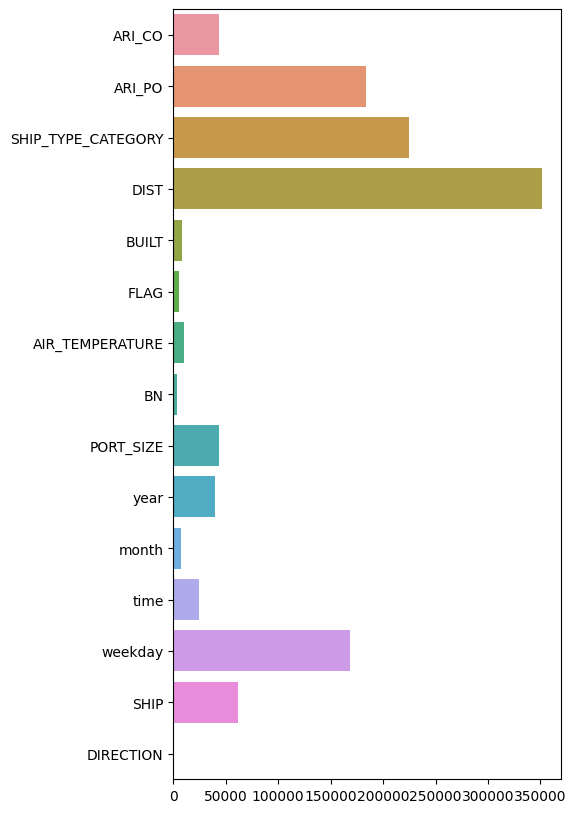

In [ ]:
plt.figure(figsize=(5,10))
sns.barplot(y=lgbm.feature_name_, x=lgbm.booster_.feature_importance(importance_type='gain'))

In [ ]:
cb_reg = CatBoostRegressor(learning_rate=0.1, iterations=500, verbose=True)

cb_reg.fit(X_train, y_train,
          early_stopping_rounds=50,
          cat_features=categorical_cols)
print(f'Train Score: {cb_reg.score(X_train,y_train)} ; Val Score: {cb_reg.score(X_valid, y_valid)}')

0:	learn: 1.4215676	total: 168ms	remaining: 1m 23s
1:	learn: 1.3922477	total: 356ms	remaining: 1m 28s
2:	learn: 1.3687974	total: 566ms	remaining: 1m 33s
3:	learn: 1.3493260	total: 718ms	remaining: 1m 28s
4:	learn: 1.3329321	total: 829ms	remaining: 1m 22s
5:	learn: 1.3175914	total: 944ms	remaining: 1m 17s
6:	learn: 1.3056152	total: 1.06s	remaining: 1m 14s
7:	learn: 1.2947146	total: 1.18s	remaining: 1m 12s
8:	learn: 1.2851502	total: 1.27s	remaining: 1m 9s
9:	learn: 1.2761674	total: 1.37s	remaining: 1m 7s
10:	learn: 1.2670921	total: 1.46s	remaining: 1m 4s
11:	learn: 1.2596774	total: 1.56s	remaining: 1m 3s
12:	learn: 1.2531214	total: 1.66s	remaining: 1m 2s
13:	learn: 1.2467277	total: 1.76s	remaining: 1m 1s
14:	learn: 1.2413439	total: 1.85s	remaining: 59.9s
15:	learn: 1.2366187	total: 1.92s	remaining: 58s
16:	learn: 1.2326806	total: 2.01s	remaining: 57.1s
17:	learn: 1.2292267	total: 2.11s	remaining: 56.6s
18:	learn: 1.2262385	total: 2.17s	remaining: 55.1s
19:	learn: 1.2236447	total: 2.25s	r

In [ ]:
pred = lgbm.predict(X_test)
pred = (np.exp(pred) - 1)/60

In [ ]:
pred = cb_reg.predict(X_test)
pred = np.exp(pred) - 1

In [ ]:
pred.min()

0.1456568580649743

In [ ]:
# if pred.min() < 0

pred = np.where(pred < 0, 0 , pred)

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.loc[X_test.index, 'CI_HOUR'] = pred
submit

,SAMPLE_ID,CI_HOUR
0,TEST_000000,2.065807
1,TEST_000001,29.157005
2,TEST_000002,24.662760
3,TEST_000003,64.816519
4,TEST_000004,0.000000
...,...,...
220486,TEST_220486,101.095450
220487,TEST_220487,52.901356
220488,TEST_220488,35.698812
220489,TEST_220489,0.000000


In [ ]:
submit.to_csv('./submit/lgbm_distreg_submit_v8.csv', index=False)

In [ ]:
submit.to_csv('./submit/catboost_distreg_submit_v4.csv', index=False)

## AutoGluon

In [ ]:
X_test = df_test[df_test['DIST']>0]

In [ ]:
trainset = TabularDataset(df_train.drop(columns=['IS_HOUR']))
testset = TabularDataset(df_test)

In [ ]:
predictor = TabularPredictor(label='CI_HOUR', eval_metric='mean_absolute_error',).fit(trainset, presets='high_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20231026_114212/"
Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231026_114212/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   26.01 GB / 107.37 GB (24.2%)
Train Data Rows:    234674
Train Data Columns: 22
Label Column: CI_HOUR
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (

In [ ]:
predictor = TabularPredictor(label='CI_HOUR', eval_metric='mean_squared_error',).fit(trainset, presets='high_quality')

In [ ]:
predictor.leaderboard()

                          model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -0.820081    1838.331407  5603.764578                0.004561           3.216956            3      False         22
1         NeuralNetTorch_BAG_L2  -0.820980    1805.229803  4557.182216                1.665927         434.821545            2      False         20
2        NeuralNetFastAI_BAG_L2  -0.834404    1807.110418  4426.109983                3.546542         303.749312            2      False         18
3               CatBoost_BAG_L2  -0.835967    1803.943720  4418.389644                0.379843         296.028973            2      False         16
4             LightGBMXT_BAG_L2  -0.836285    1832.591471  4210.510067               29.027595          88.149396            2      False         13
5          LightGBMLarge_BAG_L2  -0.836394    1816.628233  4187.157026               13.064357          64

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.820081,1838.331407,5603.764578,0.004561,3.216956,3,False,22
1,NeuralNetTorch_BAG_L2,-0.820980,1805.229803,4557.182216,1.665927,434.821545,2,False,20
2,NeuralNetFastAI_BAG_L2,-0.834404,1807.110418,4426.109983,3.546542,303.749312,2,False,18
3,CatBoost_BAG_L2,-0.835967,1803.943720,4418.389644,0.379843,296.028973,2,False,16
4,LightGBMXT_BAG_L2,-0.836285,1832.591471,4210.510067,29.027595,88.149396,2,False,13
5,LightGBMLarge_BAG_L2,-0.836394,1816.628233,4187.157026,13.064357,64.796355,2,False,21
6,XGBoost_BAG_L2,-0.836725,1807.744360,4160.183506,4.180484,37.822834,2,False,19
7,LightGBM_BAG_L2,-0.837175,1813.990921,4175.235709,10.427044,52.875038,2,False,14
8,ExtraTreesMSE_BAG_L2,-0.840539,1817.630033,4217.153600,14.066156,94.792929,2,False,17
9,RandomForestMSE_BAG_L2,-0.841763,1820.050021,4797.180411,16.486145,674.819740,2,False,15


In [ ]:
pred = predictor.predict(testset)
pred = np.exp(pred) - 1

In [ ]:
pred = predictor.predict(testset, model='WeightedEnsemble_L3')
pred = np.exp(pred) - 1

In [ ]:
pred = pred/60

In [ ]:
pred.min()

0.09340853

In [ ]:
pred = np.where(pred < 0, 0, pred)

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.loc[X_test.index, 'CI_HOUR'] = pred
submit

,SAMPLE_ID,CI_HOUR
0,TEST_000000,1.087981
1,TEST_000001,22.466228
2,TEST_000002,29.707197
3,TEST_000003,106.882187
4,TEST_000004,0.000000
...,...,...
220486,TEST_220486,114.049400
220487,TEST_220487,58.907463
220488,TEST_220488,28.549456
220489,TEST_220489,0.000000


In [ ]:
submit.to_csv('./submit/autogluon_distreg_submit_v8.csv', index=False)

In [ ]:
v4 = pd.read_csv('./submit/autogluon_distreg_submit_v4.csv')
v4

,SAMPLE_ID,CI_HOUR
0,TEST_000000,1.140239
1,TEST_000001,17.949522
2,TEST_000002,32.991352
3,TEST_000003,81.700096
4,TEST_000004,0.000000
...,...,...
220486,TEST_220486,139.626099
220487,TEST_220487,51.271927
220488,TEST_220488,23.218264
220489,TEST_220489,0.000000


In [ ]:
submit['CI_HOUR'] = submit['CI_HOUR'] * 0.2 +v4['CI_HOUR'] * 0.8
submit

,SAMPLE_ID,CI_HOUR
0,TEST_000000,1.141285
1,TEST_000001,17.993910
2,TEST_000002,33.948940
3,TEST_000003,80.566046
4,TEST_000004,0.000000
...,...,...
220486,TEST_220486,136.196336
220487,TEST_220487,51.325839
220488,TEST_220488,23.435601
220489,TEST_220489,0.000000


## Deep NN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED) # Seed 고정

In [ ]:
class RegModel(nn.Module):
  def __init__(self, input_size, output_size):
    super(RegModel, self).__init__()

    self.fc1 = nn.Linear(input_size, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256,128)
    self.fc4 = nn.Linear(128, output_size)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.relu(self.fc4(x))
    return x

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
train_target = torch.Tensor(df_train['CI_HOUR'].values)
train_input = torch.Tensor(df_train.drop(columns=['CI_HOUR', 'IS_HOUR']).values)
test_input = df_test.copy()

In [ ]:
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.1, shuffle=True, random_state=SEED)

In [ ]:
train_dataset = TensorDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=0)

val_dataset = TensorDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=0)

In [ ]:
model = RegModel(24, 1)

In [ ]:
device = torch.device('cpu')

In [ ]:
num_epochs = 100

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
best_loss = np.inf

for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')

    train_loss = 0.0
    model.train()
    print('Train Mode', end=" ")

    for batch_input, batch_target in tqdm(train_loader):
        optimizer.zero_grad()
        batch_input = batch_input.to(device)
        batch_target = batch_target.to(device)

        outputs = model(batch_input)
        loss = criterion(outputs, batch_target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f'Train Loss : {train_loss/len(train_loader):4f}')

    gc.collect()
    torch.cuda.empty_cache()

    val_loss = 0.0
    model.eval()
    print('Val Mode', end=" ")

    with torch.no_grad():
      for batch_input, batch_target in tqdm(val_loader):
        batch_input = batch_input.to(device)
        batch_target = batch_target.to(device)

        outputs = model(batch_input)
        loss = criterion(outputs, batch_target)
        val_loss += loss.item()

    print(f'Val Loss : {val_loss/len(val_loader):4f}')

    # if best_loss >= val_loss/len(val_loader):
    #     print(f'Save Model: {best_loss:.4f} -> {val_loss/len(val_loader):.4f}')
    #     best_loss = val_loss/len(val_loader)
    #     torch.save(model.state_dict(), path)


Epoch [1/100]
Train Mode 

  0%|          | 0/413 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 409/413 [00:07<00:00, 51.24it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([262])) that is different to the input size (torch.Size([262, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 413/413 [00:07<00:00, 52.19it/s]


Train Loss : 1536.837412
Val Mode 

 89%|████████▉ | 41/46 [00:00<00:00, 122.46it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([428])) that is different to the input size (torch.Size([428, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 46/46 [00:00<00:00, 125.19it/s]


Val Loss : 15.282416
Epoch [2/100]
Train Mode 

100%|██████████| 413/413 [00:06<00:00, 59.03it/s]


Train Loss : 15.162312
Val Mode 

100%|██████████| 46/46 [00:00<00:00, 118.03it/s]


Val Loss : 15.282416
Epoch [3/100]
Train Mode 

100%|██████████| 413/413 [00:06<00:00, 62.30it/s]


Train Loss : 15.162091
Val Mode 

100%|██████████| 46/46 [00:00<00:00, 168.34it/s]


Val Loss : 15.282416
Epoch [4/100]
Train Mode 

100%|██████████| 413/413 [00:06<00:00, 66.26it/s]


Train Loss : 15.162101
Val Mode 

100%|██████████| 46/46 [00:00<00:00, 119.81it/s]


Val Loss : 15.282416
Epoch [5/100]
Train Mode 

100%|██████████| 413/413 [00:06<00:00, 61.20it/s]


Train Loss : 15.161343
Val Mode 

100%|██████████| 46/46 [00:00<00:00, 127.93it/s]


Val Loss : 15.282416
Epoch [6/100]
Train Mode 

100%|██████████| 413/413 [00:06<00:00, 62.53it/s]


Train Loss : 15.162710
Val Mode 

100%|██████████| 46/46 [00:00<00:00, 140.18it/s]


Val Loss : 15.282416
Epoch [7/100]
Train Mode 

 99%|█████████▉| 409/413 [00:05<00:00, 71.21it/s]


KeyboardInterrupt: ignored

In [ ]:
model.load_state_dict(torch.load(path))

In [ ]:
torch.save(model.state_dict(), f'model/tst_model_relu_{CFG.TRAIN_WINDOW_SIZE}_bn.pt')

In [ ]:
test_dataset = CustomDataset(test_input, None)
test_loader = DataLoader(test_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    predictions = []

    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            output = model(X)

            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()

            predictions.extend(output)

    return np.array(predictions)

In [ ]:
pred = inference(model, test_loader, device)

## TabNet

In [ ]:
y_train = df_train['CI_HOUR']
X_train = df_train.drop(columns=['CI_HOUR', 'IS_HOUR'])
X_test = df_test.copy()

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=SEED)

In [ ]:
tabnet = TabNetRegressor(seed=SEED)

tabnet.fit(X_train.values, y_train.values.reshape(-1, 1), eval_set=[(X_valid.values, y_valid.values.reshape(-1, 1))],
    patience=20,
    max_epochs=1000,
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.57252 | val_0_mse: 4.89254 |  0:00:12s
epoch 1  | loss: 1.65229 | val_0_mse: 2.2025  |  0:00:21s
epoch 2  | loss: 1.60583 | val_0_mse: 1.73209 |  0:00:30s
epoch 3  | loss: 1.59705 | val_0_mse: 1.69977 |  0:00:40s
epoch 4  | loss: 1.58021 | val_0_mse: 1.61627 |  0:00:49s
epoch 5  | loss: 1.55776 | val_0_mse: 1.52233 |  0:00:58s
epoch 6  | loss: 1.54008 | val_0_mse: 1.51179 |  0:01:08s
epoch 7  | loss: 1.52731 | val_0_mse: 1.50852 |  0:01:17s
epoch 8  | loss: 1.51646 | val_0_mse: 1.49362 |  0:01:27s
epoch 9  | loss: 1.50855 | val_0_mse: 1.48378 |  0:01:36s
epoch 10 | loss: 1.50326 | val_0_mse: 1.4899  |  0:01:45s
epoch 11 | loss: 1.49901 | val_0_mse: 1.46905 |  0:01:54s
epoch 12 | loss: 1.48932 | val_0_mse: 1.46161 |  0:02:04s
epoch 13 | loss: 1.48462 | val_0_mse: 1.46225 |  0:02:13s
epoch 14 | loss: 1.48453 | val_0_mse: 1.46845 |  0:02:22s
epoch 15 | loss: 1.47694 | val_0_mse: 1.44846 |  0:02:32s
epoch 16 | loss: 1.47079 | val_0_mse: 1.45041 |  0:02:41s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
pred = tabnet.predict(X_test.values)
pred = np.exp(pred) - 1

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.loc[X_test.index, 'CI_HOUR'] = pred
submit

,SAMPLE_ID,CI_HOUR
0,TEST_000000,4.550089
1,TEST_000001,37.832985
2,TEST_000002,25.485231
3,TEST_000003,95.158882
4,TEST_000004,0.000000
...,...,...
220486,TEST_220486,79.739212
220487,TEST_220487,79.834358
220488,TEST_220488,24.011711
220489,TEST_220489,0.000000


In [ ]:
au = pd.read_csv('./submit/autogluon_distreg_submit_v4.csv')

In [ ]:
pred_ensemble = au['CI_HOUR'] *  + submit['CI_HOUR'] * 42/48

In [ ]:
pred_ensemble

0           2.845164
1          27.891253
2          29.238292
3          88.429489
4           0.000000
             ...    
220486    109.682655
220487     65.553143
220488     23.614987
220489      0.000000
220490     95.883871
Name: CI_HOUR, Length: 220491, dtype: float64

In [ ]:
submit['CI_HOUR'] = pred_ensemble

In [ ]:
submit.to_csv('./submit/tabnet+al_distreg_submit.csv', index=False)

## AutoML

In [ ]:
!pip install mljar-supervised

In [ ]:
from supervised.automl import AutoML

In [ ]:
y_train = df_train['CI_HOUR']
X_train = df_train.drop(columns=['CI_HOUR', 'IS_HOUR'])
X_test = df_test.copy()

In [ ]:
automl = AutoML(
    mode="Compete",
    eval_metric='mae',
    random_state=SEED
)

In [ ]:
automl = AutoML(results_path="AutoML_2")

In [ ]:
automl.fit(X_train, y_train)

Linear algorithm was disabled.
AutoML directory: AutoML_2
The task is regression with evaluation metric mae
AutoML will use algorithms: ['Decision Tree', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree mae 0.987588 trained in 2.39 seconds
Adjust validation. Remove: 1_DecisionTree
Validation strategy: 10-fold CV Shuffle
* Step simple_algorithms will try to check up to 3 models
1_DecisionTree mae 0.988595 trained in 19.37 seconds
2_DecisionTree mae 1.06033 trained in 12.94 seconds
3_DecisionTree mae 1.06033 trained in 13.6 s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to '

15_LightGBM_KMeansFeatures mae 0.840597 trained in 242.43 seconds
Not enough time to perform features selection. Skip
Time needed for features selection ~ 688.0 seconds
Please increase total_time_limit to at least (6943 seconds) to have features selection
Skip insert_random_feature because no parameters were generated.
Skip features_selection because no parameters were generated.
* Step hill_climbing_1 will try to check up to 14 models
25_LightGBM mae 0.823464 trained in 236.95 seconds
26_LightGBM mae 0.818807 trained in 430.79 seconds
* Step hill_climbing_2 will try to check up to 11 models
27_LightGBM mae 0.818807 trained in 448.43 seconds
Skip boost_on_errors because of the time limit.
* Step ensemble will try to check up to 1 model
Ensemble mae 0.815157 trained in 1.35 seconds
* Step stack will try to check up to 9 models
26_LightGBM_Stacked mae 0.803937 trained in 77.89 seconds
6_Xgboost_Stacked mae 0.804479 trained in 66.21 seconds
24_CatBoost_Stacked mae 0.804338 trained in 118.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


15_LightGBM_KMeansFeatures_Stacked not trained. Stop training after the first fold. Time needed to train on the first fold 5.0 seconds. The time estimate for training on all folds is larger than total_time_limit.
* Step ensemble_stacked will try to check up to 1 model
Ensemble_Stacked mae 0.803374 trained in 2.28 seconds
AutoML fit time: 3605.94 seconds
AutoML best model: Ensemble_Stacked


AutoML(eval_metric='mae', mode='Compete', random_state=42)

In [ ]:
pred = automl.predict(X_test)

In [ ]:
pred = np.exp(pred) - 1

In [ ]:
pred.min()

0.2585536704216962

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.loc[X_test.index, 'CI_HOUR'] = pred
submit

<ipython-input-34-dc710c4781f6>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2.20360213 19.58555079 31.38987353 ... 51.35426642 35.33050056
 79.6789764 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


,SAMPLE_ID,CI_HOUR
0,TEST_000000,2.203602
1,TEST_000001,19.585551
2,TEST_000002,31.389874
3,TEST_000003,87.269892
4,TEST_000004,30.258539
...,...,...
220486,TEST_220486,0.000000
220487,TEST_220487,0.000000
220488,TEST_220488,0.000000
220489,TEST_220489,0.000000


In [ ]:
submit.to_csv('./submit/automl_distreg_submit.csv', index=False)

## SHIP_TYPE_CATEGORY 별 모델

In [ ]:
dfs = [
    (df_train0, df_test0),
    (df_train1, df_test1),
    (df_train2, df_test2),
    (df_train3, df_test3),
]

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')

for dtr, dte in dfs:
  X_test = dte[dte['DIST']>0]
  trainset = TabularDataset(dtr.drop(columns=['IS_HOUR','SHIP_TYPE_CATEGORY']))
  testset = TabularDataset(dte.drop(columns=['SHIP_TYPE_CATEGORY']))

  predictor = TabularPredictor(label='CI_HOUR', eval_metric='mean_absolute_error',).fit(trainset, presets='high_quality')
  pred = predictor.predict(testset)
  pred = (np.exp(pred) - 1)/60

  if pred.min() < 0:
    pred = np.where(pred < 0, 0, pred)

  submit.loc[X_test.index, 'CI_HOUR'] = pred

No path specified. Models will be saved in: "AutogluonModels/ag-20231027_120435/"
Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231027_120435/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   40.41 GB / 107.37 GB (37.6%)
Train Data Rows:    112737
Train Data Columns: 22
Label Column: CI_HOUR
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')

for dtr, dte in dfs:
  y_train = dtr['CI_HOUR']
  X_train = dtr.drop(columns=['CI_HOUR', 'IS_HOUR','SHIP_TYPE_CATEGORY'])
  X_test = dte.copy().drop(columns=['SHIP_TYPE_CATEGORY'])

  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=SEED)

  lgbm = lgb.LGBMRegressor()
  lgbm.fit(X_train, y_train)
  print(f'Train Score: {lgbm.score(X_train,y_train)} ; Val Score: {lgbm.score(X_valid, y_valid)}')

  pred = lgbm.predict(X_test)
  pred = (np.exp(pred) - 1)/60

  if pred.min() < 0:
    pred = np.where(pred < 0, 0 , pred)

  submit.loc[X_test.index, 'CI_HOUR'] = pred

Train Score: 0.3153216847424757 ; Val Score: 0.26964096107465474
Train Score: 0.45895472652400326 ; Val Score: 0.3232242982162927
Train Score: 0.49247717043416905 ; Val Score: 0.4527913999283376
Train Score: 0.5424207200708884 ; Val Score: 0.3705848371624598


In [ ]:
submit

,SAMPLE_ID,CI_HOUR
0,TEST_000000,1.040201
1,TEST_000001,21.265226
2,TEST_000002,28.934008
3,TEST_000003,93.964035
4,TEST_000004,0.000000
...,...,...
220486,TEST_220486,59.315880
220487,TEST_220487,49.450993
220488,TEST_220488,25.596546
220489,TEST_220489,0.000000


In [ ]:
submit.to_csv('./submit/4ag_distreg_submit.csv', index=False)

## Target Encoder

In [ ]:
cat_cols = df_train.select_dtypes(include='object').columns.tolist()

In [ ]:
X = df_train.drop(columns=['CI_HOUR'])
y = df_train['CI_HOUR']

In [ ]:
from category_encoders.target_encoder import TargetEncoder

enc=TargetEncoder()

for col in cat_cols:
  X[col] = enc.fit_transform(X[col], y)
  df_test[col] = enc.transform(df_test[col])

In [40]:
X_train = X.copy()
y_train = y.copy()
X_test = df_test.copy()

In [41]:
X_test = X_test[X_test['DIST']>0]

In [42]:
sc = MinMaxScaler()

X_train[X_train.columns] = sc.fit_transform(X)
X_test[X_test.columns] = sc.transform(df_test)

In [45]:
X_train['CI_HOUR'] = y_train

In [46]:
trainset = TabularDataset(X_train)
testset = TabularDataset(X_test)

In [47]:
predictor = TabularPredictor(label='CI_HOUR', eval_metric='mean_absolute_error',).fit(trainset, presets='high_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20231030_090823/"
Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231030_090823/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   22.70 GB / 107.37 GB (21.1%)
Train Data Rows:    234646
Train Data Columns: 17
Label Column: CI_HOUR
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (

In [48]:
predictor.leaderboard()

                          model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -0.822853    2572.502986  5297.127572                0.004865           3.923310            3      False         22
1         NeuralNetTorch_BAG_L2  -0.823651    2555.814230  4643.979020                1.817385         428.563848            2      False         20
2        NeuralNetFastAI_BAG_L2  -0.837996    2557.914412  4542.668692                3.917567         327.253520            2      False         18
3               CatBoost_BAG_L2  -0.838961    2554.380280  4479.950569                0.383435         264.535397            2      False         16
4             LightGBMXT_BAG_L2  -0.839454    2583.797135  4291.738679               29.800290          76.323507            2      False         13
5          LightGBMLarge_BAG_L2  -0.840189    2566.379734  4272.851498               12.382889          57

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.822853,2572.502986,5297.127572,0.004865,3.923310,3,False,22
1,NeuralNetTorch_BAG_L2,-0.823651,2555.814230,4643.979020,1.817385,428.563848,2,False,20
2,NeuralNetFastAI_BAG_L2,-0.837996,2557.914412,4542.668692,3.917567,327.253520,2,False,18
3,CatBoost_BAG_L2,-0.838961,2554.380280,4479.950569,0.383435,264.535397,2,False,16
4,LightGBMXT_BAG_L2,-0.839454,2583.797135,4291.738679,29.800290,76.323507,2,False,13
5,LightGBMLarge_BAG_L2,-0.840189,2566.379734,4272.851498,12.382889,57.436326,2,False,21
6,XGBoost_BAG_L2,-0.840483,2556.595864,4240.045470,2.599019,24.630297,2,False,19
7,LightGBM_BAG_L2,-0.840612,2562.343073,4255.916515,8.346228,40.501343,2,False,14
8,ExtraTreesMSE_BAG_L2,-0.844157,2566.040812,4302.476791,12.043967,87.061619,2,False,17
9,RandomForestMSE_BAG_L2,-0.846066,2568.796321,4891.179116,14.799476,675.763944,2,False,15


In [49]:
pred = predictor.predict(testset)
pred = (np.exp(pred) - 1)/60

In [50]:
pred.min()

0.18500991

In [ ]:
pred = np.where(pred < 0, 0, pred)

In [51]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.loc[X_test.index, 'CI_HOUR'] = pred
submit

,SAMPLE_ID,CI_HOUR
0,TEST_000000,1.157241
1,TEST_000001,21.890314
2,TEST_000002,28.380848
3,TEST_000003,92.494476
4,TEST_000004,0.000000
...,...,...
220486,TEST_220486,63.020950
220487,TEST_220487,57.077999
220488,TEST_220488,23.146324
220489,TEST_220489,0.000000


In [52]:
submit.to_csv('./submit/autogluon_targetencoder_submit.csv', index=False)